# 1. Data Creation: 25-10-30 Load revision data

In [49]:
from preprocessing import combine_patient_data, ts_data_to_grids, load_and_process_grid, trim_nan_rows
from prob_models import run_prob
from evaluation import process_single_file

In [50]:
import glob
import pandas as pd
import tqdm
import numpy as np
from matplotlib import pyplot as plt
import os
import seaborn as sns
from pathlib import Path

In [41]:
p = '/sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20251118_1334/predictions/i0_pcase_w60_a_a_mrls_h60_fcross_d1_poly0_logit0_burn10.csv'	
df = pd.read_csv(p)
df.burn_in_days.unique()

array([10., nan])

In [45]:
df[df.burn_in_days.isna()].patient_id.unique()

array([  1.,   2.,  11.,  13.,  21.,  22.,  26.,  39.,  49.,  53.,  80.,
        93.,  94.,  95.,  98., 112., 113., 132., 133., 134., 141., 144.,
       147., 155., 157.])

In [47]:
p = '/sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20251118_1334/predictions/i10_pcase_w60_a_a_mrls_h60_fcross_d1_poly0_logit0_burn10.csv'
df = pd.read_csv(p)
df.burn_in_days.unique()

array([10., nan])

In [48]:
df[df.burn_in_days.isna()]

,hour,day,time,valid_time,activity_true,activity_pred,activity_low,activity_up,heart_true,heart_pred,...,burn_in_days,valid_days,nan_days,total_days,pid,job_index,config_patient_spec,patient_id,error,cohort
2259,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.0,1.0,1.0,'int' object is not iterable,case
2260,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.0,2.0,2.0,'int' object is not iterable,case
17953,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.0,11.0,11.0,'int' object is not iterable,case
20286,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.0,13.0,13.0,'int' object is not iterable,case
33636,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.0,21.0,21.0,'int' object is not iterable,case
33637,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.0,22.0,22.0,'int' object is not iterable,case
39640,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.0,26.0,26.0,'int' object is not iterable,case
61671,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.0,39.0,39.0,'int' object is not iterable,case
79934,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.0,49.0,49.0,'int' object is not iterable,case
86654,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.0,53.0,53.0,'int' object is not iterable,case


#### Count files per cohort: activity and sleep

Sleep is now directly loaded!

In [5]:
local_data = Path('/hpc/users/jegmij01/jannes_setup/cpp_project/revision/data/')
sleep = pd.read_csv(local_data / 'raw/fitbit_sleep_df.csv')[['participant_id','CPP.ID','group','startTime','endTime','isMainSleep']]
n_sleep_case = len(sleep[sleep.group == 'case'].participant_id.unique())
n_sleep_ctrl = len(sleep[sleep.group != 'case'].participant_id.unique())
print(n_sleep_case,n_sleep_ctrl)

FileNotFoundError: [Errno 2] No such file or directory: '/hpc/users/jegmij01/jannes_setup/cpp_project/revision/data/raw/fitbit_sleep_df.csv'

In [18]:
#!ls /sc/arion/projects/Clinical_Times_Series/cpp_data/final/2025-10-27/cppd-1/ | wc # 19
#!ls /sc/arion/projects/Clinical_Times_Series/cpp_data/final/2025-10-04/cppd-1/ | wc # 18
#!ls /sc/arion/projects/Clinical_Times_Series/cpp_data/final/2025-10-04/cppd-2__control/ | wc # 72
#!ls /sc/arion/projects/Clinical_Times_Series/cpp_data/final/2025-06-30/cppd-2__case/ | wc # 166

    166     166    6142


#### Collect time series per subject

Maybe relevant to save for benchmarks?

In [3]:
data_root = Path('/sc/arion/projects/Clinical_Times_Series/cpp_data/final/')

In [3]:
path_case = data_root / '2025-06-30/cppd-2__case/'
path_ctrl = data_root / '2025-10-04/cppd-2__control/'

data = {}
data['ctrl']= combine_patient_data(path_ctrl, sleep=True) # added sleep
#data['case'] = combine_patient_data(path_case, sleep=True)

  7%|▋         | 5/72 [00:02<00:37,  1.77it/s]

/sc/arion/projects/Clinical_Times_Series/cpp_data/final/2025-10-04/cppd-2__control/b64e7ef3-68d5-474c-8c6b-5ec3afb29757/b64e7ef3-68d5-474c-8c6b-5ec3afb29757_sleep_sleep_info.csv is empty. Skip.


 18%|█▊        | 13/72 [00:07<00:23,  2.49it/s]

/sc/arion/projects/Clinical_Times_Series/cpp_data/final/2025-10-04/cppd-2__control/b686e671-1eaa-47b6-8138-27b0fb04381c/b686e671-1eaa-47b6-8138-27b0fb04381c_heart_minute.csv is empty. Skip.
/sc/arion/projects/Clinical_Times_Series/cpp_data/final/2025-10-04/cppd-2__control/b686e671-1eaa-47b6-8138-27b0fb04381c/b686e671-1eaa-47b6-8138-27b0fb04381c_sleep_sleep_info.csv is empty. Skip.


 47%|████▋     | 34/72 [00:17<00:13,  2.85it/s]

/sc/arion/projects/Clinical_Times_Series/cpp_data/final/2025-10-04/cppd-2__control/5a2ceb93-199d-4e52-9a26-17ec7f2629bd/5a2ceb93-199d-4e52-9a26-17ec7f2629bd_sleep_sleep_info.csv is empty. Skip.


100%|██████████| 72/72 [00:36<00:00,  1.96it/s]


#### Time series to grid representation, and to disk

- run in parallel with LSF

In [35]:
window = 60
processed_path = data_root / 'processed'
_ = ts_data_to_grids(
    patient_data = data['ctrl'],
    processed_path = processed_path,
    window = window,
    nan_thres_per_window = 0.3 # below this, make window nan
)

In [34]:
# load back
windows = [1,5,15,30,60]
window = 60
processed_path = f'/sc/arion/projects/Clinical_Times_Series/cpp_data/final/processed/case/revision_nan_all_patients_{window}.npz'
data = np.load(processed_path,allow_pickle=True)
data['modalities']
len(data['metadata'])

159

#### Select calibration patients

In [134]:
res = [{'pid':pid, 'total':data['data'][pid][:,:,0].size, 'valid':(np.isnan(data['data'][pid][:,:,0])==False).sum()} for pid in range(159)]

[125  18 109  19  44 104  43  50 153   4  45 108  91  25 156  81  52   9
 138]


,pid,total,valid,total_d,valid_d,ratio,idx,patient_id,patient_count,n_days,n_time_bins
140,125,2280,2057,95.0,85.708333,0.902193,140,415132bd-4b76-49a7-882a-5da25f58a23b,125,95,24
141,18,2304,2082,96.0,86.750000,0.903646,141,34cd0e46-4933-4459-ace9-3e2da255d5f2,18,96,24
142,109,2376,2148,99.0,89.500000,0.904040,142,4418b6bb-34ab-475a-819e-bc680dab2785,109,99,24
143,19,2328,2125,97.0,88.541667,0.912801,143,859aa274-d83f-4d5e-9a5b-29b17b45f29e,19,97,24
144,44,2400,2205,100.0,91.875000,0.918750,144,42d837cd-f243-4e34-874f-ea1dac32af0e,44,100,24
145,104,2208,2031,92.0,84.625000,0.919837,145,cd895d8e-d560-41bd-97db-51f4d6a00264,104,92,24
146,43,2304,2122,96.0,88.416667,0.921007,146,8a7ab11b-d330-4b52-a34f-7e13c49206e0,43,96,24
147,50,2208,2035,92.0,84.791667,0.921649,147,09a86c7e-5d72-45a1-9860-d3bd0f58b761,50,92,24
148,153,2208,2070,92.0,86.250000,0.937500,148,d65269c9-2d63-4820-99e7-cab838864e35,153,92,24
149,4,2280,2154,95.0,89.750000,0.944737,149,4bbfa829-7a36-4752-80d4-95a1f7e31e1d,4,95,24


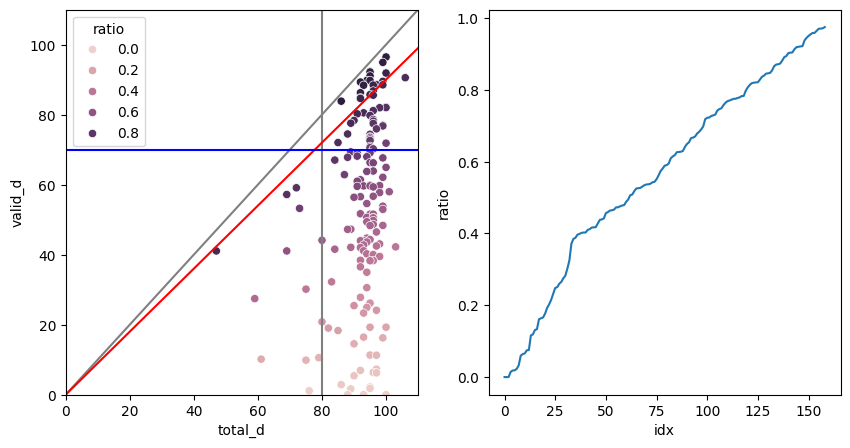

In [135]:
thres = 0.90

df = pd.DataFrame(res)
df['total_d'] = df['total'] / 24
df['valid_d'] = df['valid'] / 24
df['ratio'] = df['valid']/df['total']

f,(ax1,ax2)=plt.subplots(1,2,figsize=[10,5])
# fig 1
df = df.sort_values("valid", ascending=False).reset_index(drop=True)
ax=sns.scatterplot(df, x='total_d',y='valid_d', hue=df['ratio'],ax=ax1)
ax.set_xlim([0,110])
ax.set_ylim([0,110])
ax.plot([0,110],[0,110],c='gray')
ax.plot([80,80],[0,110],c='gray')
ax.plot([0,110],[0,110*thres],c='red')
ax.plot([0,110],[70,70],c='blue')

# fig 2
df = df.sort_values("ratio", ascending=True)
df['idx'] = np.arange(len(df))
#df = df.sort_values("ratio", ascending=True).reset_index()
ax=sns.lineplot(df, x='idx',y='ratio',ax=ax2)

# gen output
meta = pd.DataFrame.from_records(data['metadata'])
meta['pid'] = meta['patient_count']
df = df.merge(meta, how='left', on='pid')

print(df[df['ratio']>thres].pid.unique())
df[df['ratio']>thres]

# 2. Update Run Function

In [107]:
window = 5
patient_id = 4
processed_path = f'/sc/arion/projects/Clinical_Times_Series/cpp_data/final/processed/case/revision_nan_all_patients_{window}.npz'

res = run_prob(
                        processed_path,
                        model_name='logit_rls',
                        patient_id=patient_id,
                        kernel_day=3,
                        n_kernel_recent=5,
                        field='cross',
                        lambda_forget=0.999,
                        initial_uncertainty=100,
                        verbose=1,
                        min_days=20,
                        forecasting_modality='a|a',
                        prediction_horizon=60
                    )

res = pd.DataFrame(res)

# plot:
#ax = sns.lineplot(res, x='time',y='activity_true')
#sns.lineplot(res, x='time',y='activity_pred',ax=ax)
#ax.set_xlim([1,3])

Model: logit_rls (λ=0.999)
Forecasting mode: a|ah
Field: cross
Time resolution: 5min
Prediction horizon: 60min (12 steps)
Valid days: 88.7, NaN days: 5.3, Total days: 94
Completed: 26808 time points in output


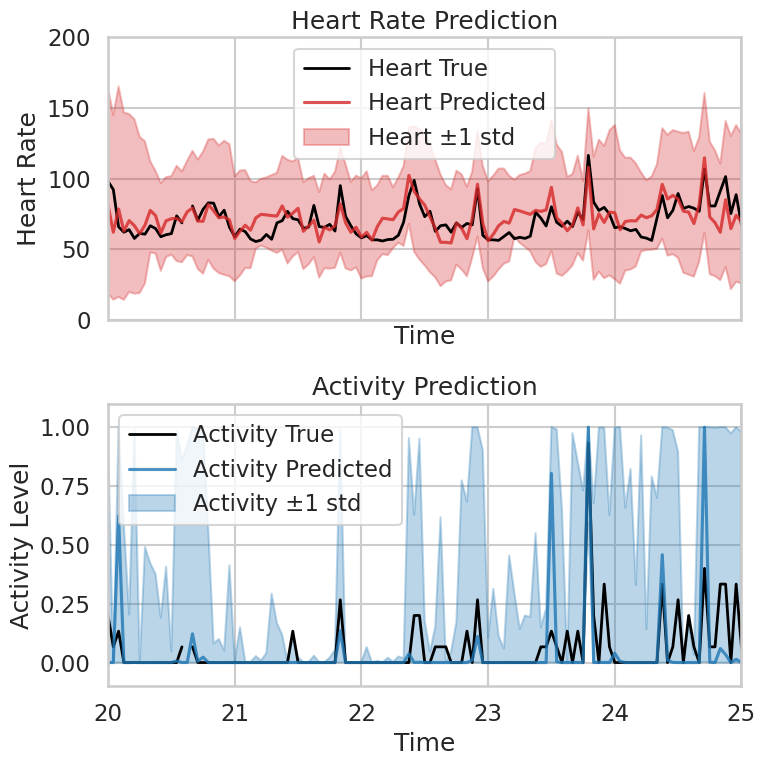

In [117]:
import matplotlib.pyplot as plt
import seaborn as sns

df = res[res.prediction_index==0].copy()

# optional: seaborn styling
sns.set(style="whitegrid", context="talk")

fig, axes = plt.subplots(2, 1, figsize=(8, 8), sharex=True)

plt.xlim([20,25])

# --- Plot 1: Heart rate ---
ax = axes[0]

ax.plot(df['time'], df['heart_true'], label='Heart True', color='black', linewidth=2)
ax.plot(df['time'], df['heart_pred'], label='Heart Predicted', color='tab:red', alpha=0.8)
ax.fill_between(
    df['time'],
    df['heart_low'],
    df['heart_up'],
    color='tab:red',
    alpha=0.3,
    label='Heart ±1 std'
)
ax.set_title('Heart Rate Prediction')
ax.set_xlabel('Time')
ax.set_ylabel('Heart Rate')
ax.legend()
ax.set_ylim([0,200])

# --- Plot 2: Activity ---
ax = axes[1]

ax.plot(df['time'], df['activity_true'], label='Activity True', color='black', linewidth=2)
ax.plot(df['time'], df['activity_pred'], label='Activity Predicted', color='tab:blue', alpha=0.8)
ax.fill_between(
    df['time'],
    df['activity_low'],
    df['activity_up'],
    color='tab:blue',
    alpha=0.3,
    label='Activity ±1 std'
)
ax.set_title('Activity Prediction')
ax.set_xlabel('Time')
ax.set_ylabel('Activity Level')
ax.legend()
ax.set_ylim([-0.1,1.1])

plt.tight_layout()
plt.show()


# 3. load metrics

- ✓ Saved 48564 rows to /sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20251112_1611/results/metadata.csv
- ✓ Saved 291384 rows to /sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20251112_1611/results/regression.csv
- ✓ Saved 291384 rows to /sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20251112_1611/results/classification_auc.csv
- ✓ Saved 291384 rows to /sc/arion/projects/Clinical_Times_Series/cpp_data/runs/20251112_1611/results/classification_threshold.csv

In [255]:
from scipy import stats
from itertools import combinations

class MetricExplorer:
    """Helper class for exploring metrics across conditions."""
    
    def __init__(self, data_df, metadata_df, metrics=None):
        """Initialize with merged data."""
        self.data = (
            data_df.merge(metadata_df, on=['pid','run'], how='left')
        )
        self.metrics = metrics if metrics else ['r2', 'rmse', 'mae']
        self.cols = len(self.metrics)
    
    def filter(self, **kwargs):
        """Filter data by conditions."""
        filtered = self.data.copy()
        for col, val in kwargs.items():
            if isinstance(val, list):
                filtered = filtered[filtered[col].isin(val)]
            else:
                filtered = filtered[filtered[col] == val]

        assert len(filtered), f'empty for {kwargs}'
        return filtered

    def print_unique_values(self, max_print=30):
        """Print unique values for all columns in the data."""
        for col in self.data.columns:
            unique_vals = self.data[col].nunique()
            if unique_vals <= max_print:
                print(f"{col} ({unique_vals}): {sorted(self.data[col].unique())}")
            else:
                print(f"{col}: {unique_vals} unique values")        
    
    def plot_comparison(self, x, hue, fixed_conditions=None, **plot_kwargs):
        """Quick comparison plot for all metrics."""
        df = self.filter(**fixed_conditions) if fixed_conditions else self.data
        
        fig, axes = plt.subplots(1, self.cols, figsize=(4*self.cols, 5))
        for ax, metric in zip(axes, self.metrics):
            sns.barplot(data=df, x=x, y=metric, hue=hue, ax=ax, **plot_kwargs)
            ax.set_title(f'{metric.upper()}')
            if metric == 'r2':
                ax.set_ylim([-0.1, 1])
        
        plt.tight_layout()
        return fig, axes

    def plot_lines(self, x, hue, fixed_conditions=None, **plot_kwargs):
        """Line plot with shaded uncertainty for all metrics."""
        df = self.filter(**fixed_conditions) if fixed_conditions else self.data
        
        fig, axes = plt.subplots(1, self.cols, figsize=(4*self.cols, 5))
        for ax, metric in zip(axes, self.metrics):
            sns.lineplot(data=df, x=x, y=metric, hue=hue, ax=ax, **plot_kwargs, marker='o')
            ax.set_title(f'{metric.upper()}')
            if metric == 'r2':
                ax.set_ylim([-0.1, 1])
        
        plt.tight_layout()
        return fig, axes

    
    def facet_explore(self, x, hue, row=None, col=None, metric='r2', **fixed_conditions):        
        """ Usage:       
            explorer.facet_explore(
            x='forecasting_modality',
            hue='T_eff',
            row='kernel_hour',
            col='field',
            metric='rmse'
            )
        """
        df = self.filter(**fixed_conditions)
        g = sns.FacetGrid(df, row=row, col=col, height=4, aspect=1.2)
        g.map_dataframe(sns.barplot, x=x, y=metric, hue=hue)
        g.add_legend()
        return g
    
    def plot_scatter_ci(self, x, metric='r2', hue=None, fixed_conditions=None, 
                        ci='sd', figsize=(8, 5), alpha=0.5, **plot_kwargs):
        """
        Scatter plot with mean and confidence intervals.
        
        Parameters
        ----------
        x : str
            Column for x-axis groups (e.g., 'field', 'forecasting_modality')
        metric : str
            Metric to plot ('r2', 'rmse', or 'mae')
        hue : str, optional
            Column for color coding the scatter points (e.g., 'pid', 'T_eff')
        fixed_conditions : dict, optional
            Conditions to filter on, e.g., {'kernel_hour': 5, 'T_eff': 0.5}
        ci : str or int, optional
            Confidence interval type: 'sd' (standard deviation), 95 (95% CI), 
            or None for no error bars
        figsize : tuple
            Figure size
        alpha : float
            Transparency of scatter points
        **plot_kwargs : 
            Additional arguments (e.g., dodge, jitter settings)
            
        Returns
        -------
        fig, ax
        """    
        
        # Filter data
        df = self.filter(**fixed_conditions) if fixed_conditions else self.data
        
        # Create figure
        fig, ax = plt.subplots(figsize=figsize)

        # Mean + CI bars (always in black, no hue)
        sns.pointplot(
            data=df,
            x=x,
            y=metric,
            join=False,
            errorbar=ci,  # 'sd', ('ci', 95), or None
            color='black',
            errwidth=2,
            markers='D',
            markersize=5,
            ax=ax,
            legend=False
        )

        
        # Underlying scatter points with optional hue
        stripplot_kwargs = {
            'dodge': False,
            'jitter': True,
            'alpha': alpha,
        }
        stripplot_kwargs.update(plot_kwargs)
        
        if hue is None:
            stripplot_kwargs['color'] = 'gray'
            sns.stripplot(
                data=df,
                x=x,
                y=metric,
                ax=ax,
                **stripplot_kwargs
            )
        else:
            sns.stripplot(
                data=df,
                x=x,
                y=metric,
                hue=hue,
                ax=ax,
                **stripplot_kwargs
            )
        
        
        # Styling
        ax.set_ylabel(metric.upper())
        ax.set_xlabel(x.replace('_', ' ').title())
        
        # Auto-adjust y-limits based on metric
        if metric == 'r2':
            ax.set_ylim([-0.1, 1.05])
        elif metric in ['rmse', 'mae']:
            ax.set_ylim([0, None])
        
        # Add grid for readability
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.set_axisbelow(True)
        
        plt.tight_layout()
        return fig, ax        


    def compute_pairwise_tests(self, x, metric='r2', reference=None, 
                               fixed_conditions=None, test='wilcoxon',
                               paired=True, pairing_var=None):
        """
        Compute pairwise statistical tests between groups.
        
        Parameters
        ----------
        x : str
            Column defining groups (e.g., 'model_name')
        metric : str
            Metric to compare ('r2', 'rmse', 'mae')
        reference : str, optional
            Reference group name. If provided, only compare other groups to this reference.
            If None, perform all pairwise comparisons.
        fixed_conditions : dict, optional
            Conditions to filter on
        test : str
            Statistical test: 'wilcoxon' (paired), 't-test' (paired), 
            'mann-whitney' (unpaired), 't-test-ind' (unpaired)
        paired : bool
            Whether data is paired (same subjects across groups)
        pairing_var : str, optional
            Variable that defines pairing (e.g., 'pid', 'subject_id').
            Required if paired=True.
            
        Returns
        -------
        results : pd.DataFrame
            DataFrame with columns: group1, group2, p_value, significant, 
            effect_size, test_statistic
        """
        # Filter data
        df = self.filter(**fixed_conditions) if fixed_conditions else self.data.copy()
        
        # Get unique groups
        groups = df[x].unique()
        
        # Determine which comparisons to make
        if reference is not None:
            if reference not in groups:
                raise ValueError(f"Reference '{reference}' not found in {x} column")
            # Only compare reference to other groups
            comparisons = [(reference, g) for g in groups if g != reference]
        else:
            # All pairwise comparisons
            comparisons = list(combinations(groups, 2))
        
        results = []
        
        for g1, g2 in comparisons:
            data1 = df[df[x] == g1]
            data2 = df[df[x] == g2]
            
            if paired:
                if pairing_var is None:
                    raise ValueError("pairing_var must be specified for paired tests")
                
                # Align data by pairing variable
                merged = pd.merge(
                    data1[[pairing_var, metric]],
                    data2[[pairing_var, metric]],
                    on=pairing_var,
                    suffixes=('_1', '_2')
                )
                
                if len(merged) == 0:
                    print(f"Warning: No paired observations for {g1} vs {g2}")
                    continue
                
                vals1 = merged[f'{metric}_1'].values
                vals2 = merged[f'{metric}_2'].values
                
                # Perform paired test
                if test == 'wilcoxon':
                    stat, p_value = stats.wilcoxon(vals1, vals2, alternative='two-sided')
                elif test == 't-test':
                    stat, p_value = stats.ttest_rel(vals1, vals2)
                else:
                    raise ValueError(f"Unknown paired test: {test}")
                
                # Cohen's d for effect size (paired)
                diff = vals1 - vals2
                effect_size = np.mean(diff) / np.std(diff, ddof=1)
                n_obs = len(vals1)
                
            else:
                # Unpaired tests
                vals1 = data1[metric].values
                vals2 = data2[metric].values
                
                if test == 'mann-whitney':
                    stat, p_value = stats.mannwhitneyu(vals1, vals2, alternative='two-sided')
                elif test == 't-test-ind':
                    stat, p_value = stats.ttest_ind(vals1, vals2)
                else:
                    raise ValueError(f"Unknown unpaired test: {test}")
                
                # Cohen's d for effect size (unpaired)
                pooled_std = np.sqrt((np.var(vals1, ddof=1) + np.var(vals2, ddof=1)) / 2)
                effect_size = (np.mean(vals1) - np.mean(vals2)) / pooled_std
                n_obs = min(len(vals1), len(vals2))
            
            results.append({
                'group1': g1,
                'group2': g2,
                'p_value': p_value,
                'p_value_adjusted': p_value,  # Will adjust later if needed
                'significant': p_value < 0.05,
                'effect_size': effect_size,
                'test_statistic': stat,
                'n_observations': n_obs
            })
        
        results_df = pd.DataFrame(results)
        
        # Apply Bonferroni correction for multiple comparisons
        if len(results_df) > 1:
            results_df['p_value_adjusted'] = results_df['p_value'] * len(results_df)
            results_df['p_value_adjusted'] = results_df['p_value_adjusted'].clip(upper=1.0)
            results_df['significant'] = results_df['p_value_adjusted'] < 0.05
        
        return results_df
    
    def _get_significance_symbol(self, p_value):
        """Convert p-value to significance symbols."""
        if p_value < 0.001:
            return '***'
        elif p_value < 0.01:
            return '**'
        elif p_value < 0.05:
            return '*'
        else:
            return 'ns'
    
    def _draw_significance_bracket(self, ax, x1, x2, y, p_value, height=0.02):
        """Draw a significance bracket between two x positions."""
        symbol = self._get_significance_symbol(p_value)
        
        # Bracket line style
        color = 'black' if p_value < 0.05 else 'gray'
        linewidth = 1.5 if p_value < 0.05 else 1.0
        
        # Draw bracket
        bracket_height = height
        ax.plot([x1, x1, x2, x2], 
                [y, y + bracket_height, y + bracket_height, y], 
                color=color, linewidth=linewidth)
        
        # Add significance symbol
        ax.text((x1 + x2) / 2, y + bracket_height, symbol,
                ha='center', va='bottom', fontsize=10, fontweight='bold',
                color=color)
    
    def plot_stats(self, x, metric='r2', hue=None, fixed_conditions=None, 
                        ci='sd', figsize=(8, 5), alpha=0.5,
                        add_stats=False, stats_reference=None, test='wilcoxon',
                        paired=True, pairing_var=None, show_effect_size=False,
                        **plot_kwargs):
        """
        Scatter plot with mean and confidence intervals, optionally with statistical comparisons.
        
        Parameters
        ----------
        x : str
            Column for x-axis groups (e.g., 'model_name', 'field')
        metric : str
            Metric to plot ('r2', 'rmse', or 'mae')
        hue : str, optional
            Column for color coding the scatter points (e.g., 'pid', 'T_eff')
        fixed_conditions : dict, optional
            Conditions to filter on, e.g., {'kernel_hour': 5, 'T_eff': 0.5}
        ci : str or int, optional
            Confidence interval type: 'sd' (standard deviation), 95 (95% CI), 
            or None for no error bars
        figsize : tuple
            Figure size
        alpha : float
            Transparency of scatter points
        add_stats : bool
            Whether to add statistical comparison brackets
        stats_reference : str, optional
            Reference group for comparisons. If None and add_stats=True, 
            the group with best mean metric is used as reference.
        test : str
            Statistical test: 'wilcoxon', 't-test', 'mann-whitney', 't-test-ind'
        paired : bool
            Whether data is paired
        pairing_var : str, optional
            Variable defining pairing (required if paired=True and add_stats=True)
        show_effect_size : bool
            Whether to print effect sizes in console
        **plot_kwargs : 
            Additional arguments (e.g., dodge, jitter settings)
            
        Returns
        -------
        fig, ax : matplotlib figure and axis
        stats_results : pd.DataFrame (only if add_stats=True)
            Statistical test results
        """    
        
        # Filter data
        df = self.filter(**fixed_conditions) if fixed_conditions else self.data
        
        # Create figure
        fig, ax = plt.subplots(figsize=figsize)
        
        # Mean + CI bars (always in black, no hue)
        sns.pointplot(
            data=df,
            x=x,
            y=metric,
            join=False,
            errorbar=ci,
            color='black',
            errwidth=2,
            markers='D',
            markersize=5,
            ax=ax,
            legend=False
        )
        
        # Underlying scatter points with optional hue
        stripplot_kwargs = {
            'dodge': False,
            'jitter': True,
            'alpha': alpha,
        }
        stripplot_kwargs.update(plot_kwargs)
        
        if hue is None:
            stripplot_kwargs['color'] = 'gray'
            sns.stripplot(
                data=df,
                x=x,
                y=metric,
                ax=ax,
                **stripplot_kwargs
            )
        else:
            sns.stripplot(
                data=df,
                x=x,
                y=metric,
                hue=hue,
                ax=ax,
                **stripplot_kwargs
            )
        
        # Styling
        ax.set_ylabel(metric.upper())
        ax.set_xlabel(x.replace('_', ' ').title())
        
        # Auto-adjust y-limits based on metric
        if metric == 'r2':
            ax.set_ylim([-0.1, 1.05])
        elif metric in ['rmse', 'mae']:
            ax.set_ylim([0, None])
        
        # Statistical comparisons
        stats_results = None
        if add_stats:
            # Determine reference group if not specified
            if stats_reference is None:
                group_means = df.groupby(x)[metric].mean()
                if metric == 'r2':
                    stats_reference = group_means.idxmax()  # Higher is better
                else:  # rmse, mae
                    stats_reference = group_means.idxmin()  # Lower is better
                print(f"Using '{stats_reference}' as reference (best mean {metric})")
            
            # Compute statistical tests
            stats_results = self.compute_pairwise_tests(
                x=x,
                metric=metric,
                reference=stats_reference,
                fixed_conditions=fixed_conditions,
                test=test,
                paired=paired,
                pairing_var=pairing_var
            )
            
            # Display effect sizes if requested
            if show_effect_size:
                print("\nEffect Sizes (Cohen's d):")
                for _, row in stats_results.iterrows():
                    print(f"  {row['group1']} vs {row['group2']}: "
                          f"d = {row['effect_size']:.3f}")
            
            # Add brackets to plot
            groups = df[x].unique()
            group_positions = {g: i for i, g in enumerate(groups)}
            
            # Get y-range for positioning brackets
            y_max = ax.get_ylim()[1]
            y_min = ax.get_ylim()[0]
            y_range = y_max - y_min
            
            # Starting height for brackets (5% above max data)
            bracket_start = y_max - 0.05 * y_range
            bracket_spacing = 0.08 * y_range
            
            for idx, row in stats_results.iterrows():
                x1 = group_positions[row['group1']]
                x2 = group_positions[row['group2']]
                y_pos = bracket_start + idx * bracket_spacing
                
                self._draw_significance_bracket(
                    ax, x1, x2, y_pos, 
                    row['p_value_adjusted'],
                    height=0.03 * y_range
                )
            
            # Adjust y-limit to accommodate brackets
            n_comparisons = len(stats_results)
            new_y_max = bracket_start + (n_comparisons + 0.5) * bracket_spacing
            ax.set_ylim([y_min, new_y_max])
            
            # Add legend for significance levels
            legend_text = "* p < 0.05\n** p < 0.01\n*** p < 0.001\nns = not significant"
            ax.text(0.98, 0.98, legend_text, transform=ax.transAxes,
                   fontsize=8, verticalalignment='top', horizontalalignment='right',
                   bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
        
        # Add grid for readability
        ax.grid(axis='y', alpha=0.3, linestyle='--')
        ax.set_axisbelow(True)
        
        plt.tight_layout()
        
        if add_stats:
            return fig, ax, stats_results
        else:
            return fig, ax        

In [81]:
!ls '/sc/arion/projects/Clinical_Times_Series/cpp_data/runs/'

20251112_1611  20251114_1712  20251114_1740  20251114_1855  20251114_1856


In [6]:
import glob
import tqdm
from evaluation import evaluate_run
import warnings

# 20251112_1611 <-- test
# 20251114_1712 <-- experiment 1: T_eff, P0
# 20251114_1740 <-- experiment 2: modalities
# 20251117_1351 <-- ex1, smaller P0 

# Experiment 1:


def init(run, metrics=None):
    """ factory funct """
    
    runs_path =  Path(f'/sc/arion/projects/Clinical_Times_Series/cpp_data/runs/{run}/')
    table_path = runs_path / 'results'
    
    meta = pd.read_csv(table_path / 'metadata.csv')
    reg = pd.read_csv(table_path / 'regression.csv')
    auc = pd.read_csv(table_path / 'classification_auc.csv')
    
    # time window in days
    meta['T_eff'] = np.round(-meta['dt']/np.log(meta['lambda_forget']) / (24*60)).astype(int) # convert to days
    
    # compute tot pars
    h_flag = ~meta['forecasting_modality'].isin(['a|a'])
    a_flag = ~meta['forecasting_modality'].isin(['a|h'])
    meta['pars_tot'] = meta['n_pars_heart']*h_flag + meta['n_pars_activity']*a_flag

    return MetricExplorer(reg, meta,metrics=metrics)

run = '20251117_1351'
explorer = init(run)

In [127]:
explorer.data.kernel_hour.unique()

array([5.])

## Experiment 1

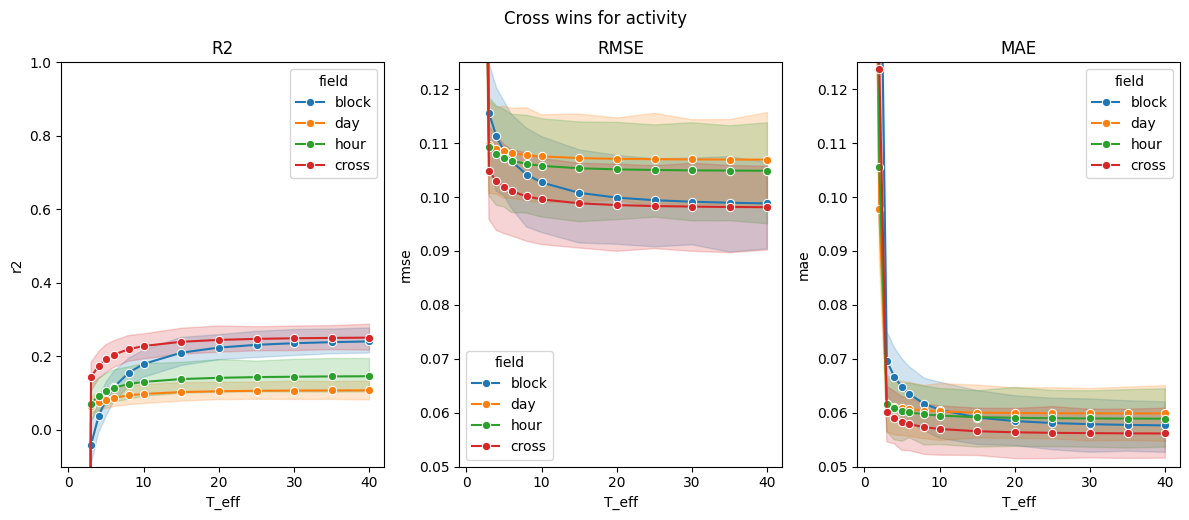

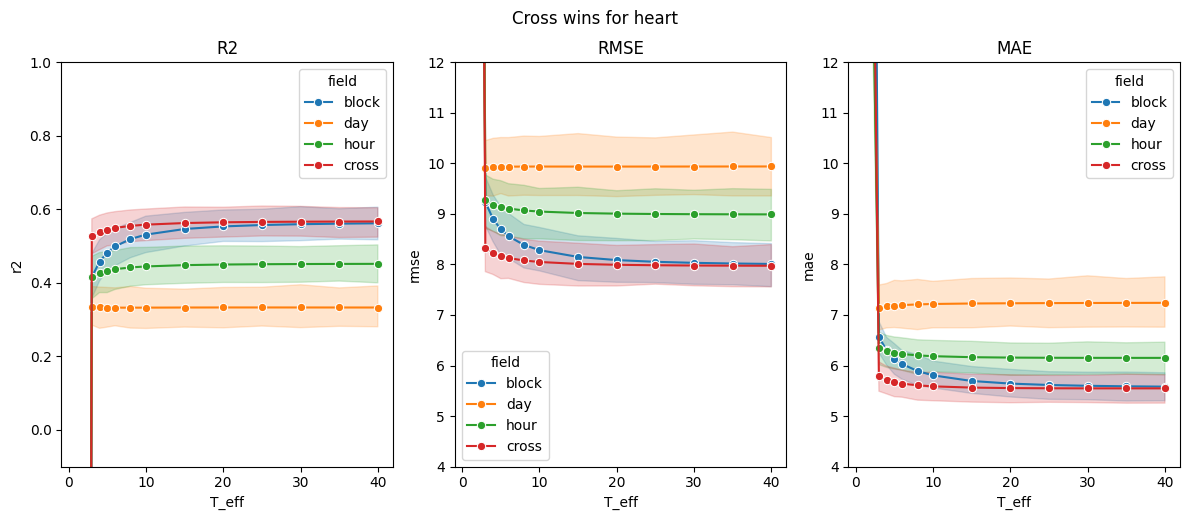

(None, None)

In [128]:
# activity
f,axs=explorer.plot_lines(
        hue='field',
        x='T_eff',
        #marker='o',
        fixed_conditions={'kernel_hour': 5, 'kernel_day': 5, 'initial_uncertainty':5,
                          'forecasting_modality': 'a|a', 
                          'task':'activity', 'condition':'all'}
)
[axs[i].set_ylim([0.05,0.125]) for i in [1,2]]
f.suptitle('Cross wins for activity', y=1.03)
plt.show(), plt.close()

# heart
f,axs=explorer.plot_lines(
        hue='field',
        x='T_eff',
        #marker='o',
        fixed_conditions={'kernel_hour': 5, 'kernel_day': 5, 'initial_uncertainty':5,
                          'forecasting_modality': 'a|a', 
                          'task':'heart', 'condition':'all'}
)
[axs[i].set_ylim([4,12]) for i in [1,2]]
f.suptitle('Cross wins for heart', y=1.03)
plt.show(), plt.close()

Using 'cross' as reference (best mean rmse)

Effect Sizes (Cohen's d):
  cross vs block: d = -2.755
  cross vs hour: d = -2.376
  cross vs day: d = -1.520


(<Figure size 500x500 with 1 Axes>,
 <Axes: xlabel='Field', ylabel='RMSE'>,
   group1 group2  p_value  p_value_adjusted  significant  effect_size  \
 0  cross  block      0.0               0.0         True    -2.755188   
 1  cross   hour      0.0               0.0         True    -2.376111   
 2  cross    day      0.0               0.0         True    -1.519762   
 
    test_statistic  n_observations  
 0             0.0            2736  
 1             0.0            2736  
 2             0.0            2736  )

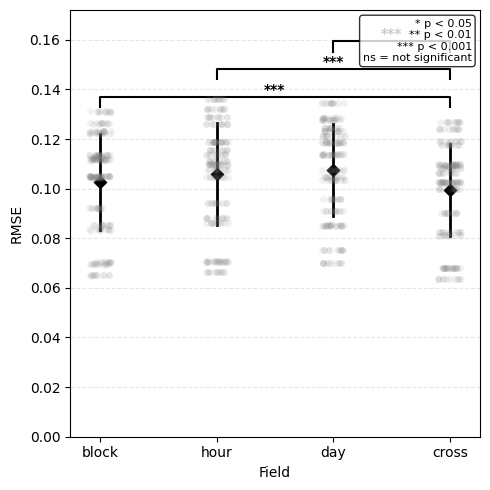

In [138]:
# activity
explorer.plot_stats(x='field', ci='sd', figsize=(5,5), metric='rmse', alpha=0.1,
                         fixed_conditions={'kernel_hour': 5, 'kernel_day': 5, 
                          'forecasting_modality': 'a|a', 
                          'task':'activity', 'condition':'all', 'T_eff':10},
                            add_stats=True,
                            paired=True,
                            pairing_var='pid',
                            test='wilcoxon',
                            show_effect_size=True
                            )

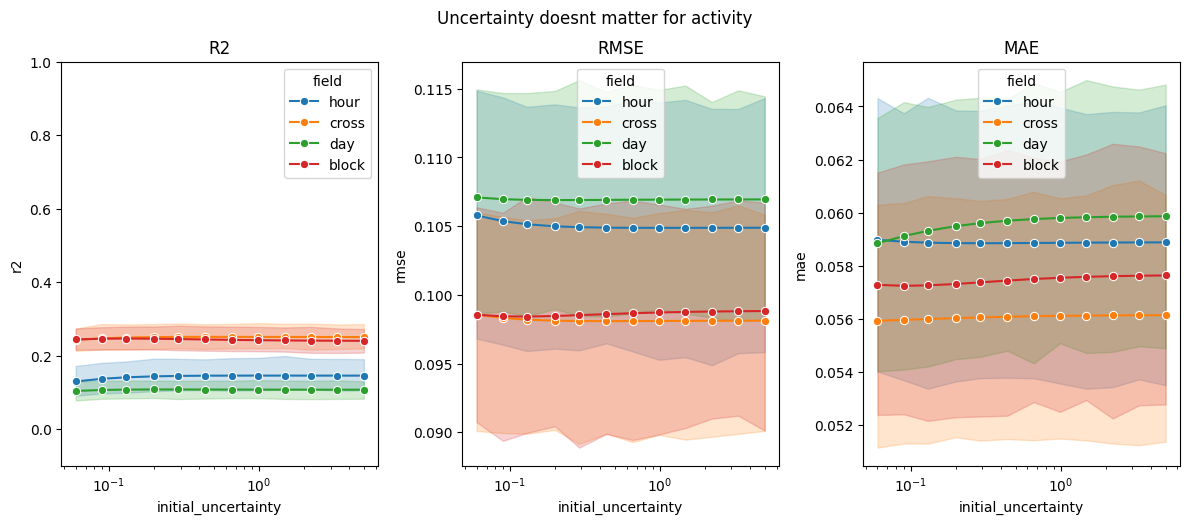

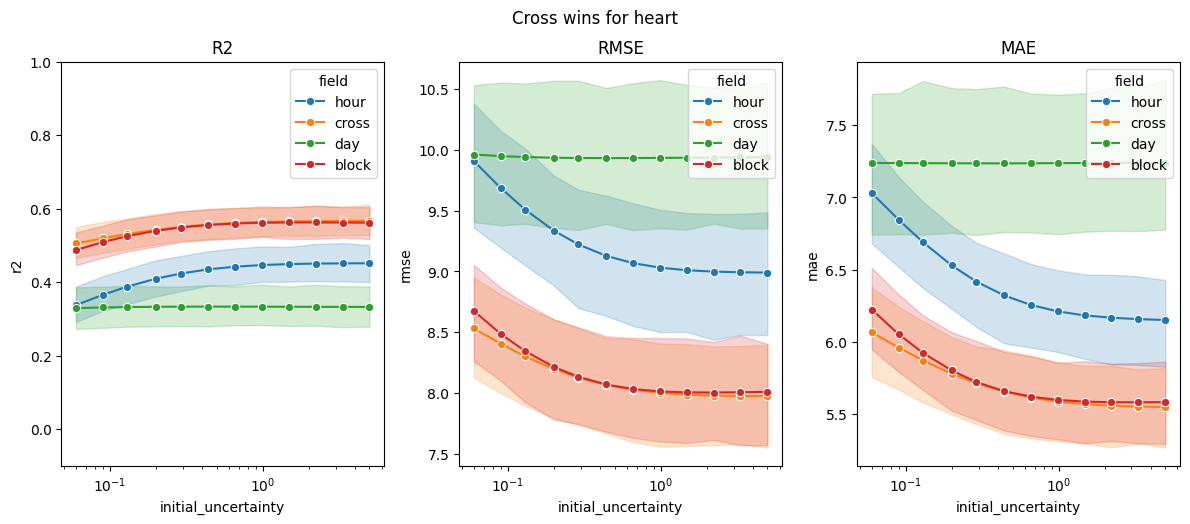

(None, None)

In [119]:
# activity
f,axs=explorer.plot_lines(
        hue='field',
        x='initial_uncertainty',
        #marker='o',
        fixed_conditions={'kernel_hour': 5, 'kernel_day': 5, 'T_eff':40,
                          'forecasting_modality': 'a|a', 
                          'task':'activity', 'condition':'all'}
)
for ax in axs:
    ax.set_xscale('log')

f.suptitle('Uncertainty doesnt matter for activity', y=1.03)
plt.show(), plt.close()

# heart
f,axs=explorer.plot_lines(
        hue='field',
        x='initial_uncertainty',
        #marker='o',
        fixed_conditions={'kernel_hour': 5, 'kernel_day': 5, 'T_eff':40,
                          'forecasting_modality': 'a|a', 
                          'task':'heart', 'condition':'all'}
)
for ax in axs:
    ax.set_xscale('log')

f.suptitle('Cross wins for heart', y=1.03)
plt.show(), plt.close()

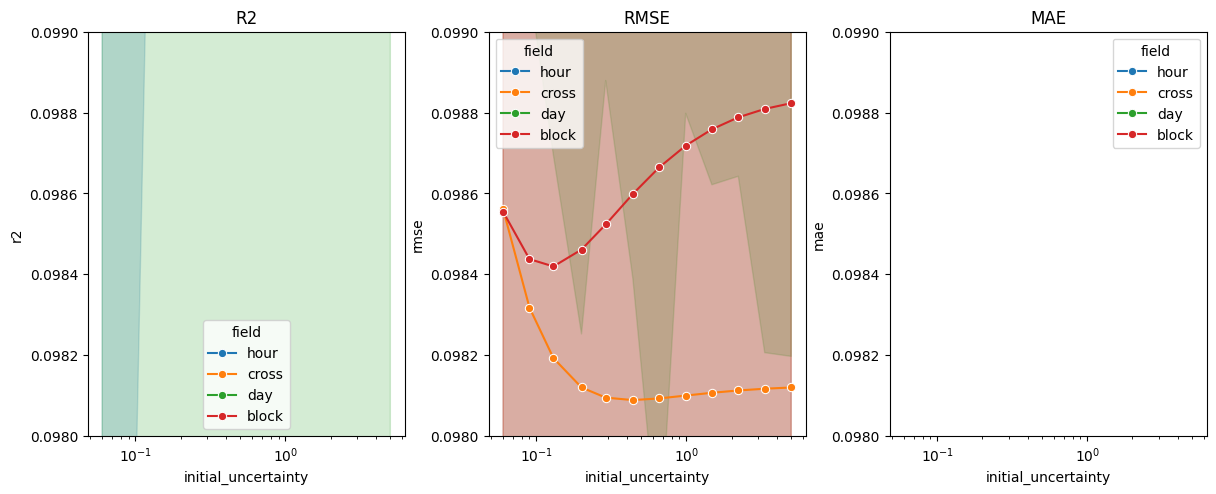

In [124]:
# activity
f,axs=explorer.plot_lines(
        hue='field',
        x='initial_uncertainty',
        #marker='o',
        fixed_conditions={'kernel_hour': 5, 'kernel_day': 5, 'T_eff':40, #'field':'block',
                          'forecasting_modality': 'a|a', 
                          'task':'activity', 'condition':'all'}
)
for ax in axs:
    ax.set_xscale('log')
    ax.set_ylim([0.098,0.099])

## Experiment 2: shows Linear is best.

- Diag vs Full
- Linear vs Poly
- Logit vs Gauss

In [110]:
run = '20251114_1740' # redo with 47
explorer = init(run)

def fmt(diag, poly, logit):
    return (
        ("Diag" if diag else "Full") + "_" +
        ("Poly" if poly else "Linear") + "_" +
        ("Logit" if logit else "Gauss")
    )

explorer.data["model_config"] = [
    fmt(d, p, l)
    for d, p, l in zip(
        explorer.data["diagonal_covariance"],
        explorer.data["use_polynomial"],
        explorer.data["use_logit_space"]
    )
]

In [111]:
explorer.data.initial_uncertainty.unique()

array([ 13.,  24.,   4.,   6.,  75.,  18., 100.,  32.,  10.,   8.,  42.,
        56.])

In [34]:
explorer.data

,task,condition,rmse,mae,r2,corr,n,path_x,run,pid,...,n_after_burnin,sleep_n_nan,sleep_n_true,sleep_n_false,n_total_rows,n_before_dropna,n_after_dropna,T_eff,pars_tot,model_config
0,activity,all,0.173930,0.101495,-0.652511,0.330924,1858,/sc/arion/projects/Clinical_Times_Series/cpp_d...,0,125,...,2016,158,498,1224,2016,2016,1858,10,886,Diag_Poly_Gauss
1,activity,sleep_false,0.211153,0.139436,-1.036572,0.185385,1224,/sc/arion/projects/Clinical_Times_Series/cpp_d...,0,125,...,2016,158,498,1224,2016,2016,1858,10,886,Diag_Poly_Gauss
2,activity,sleep_true,0.045953,0.024039,-114.713498,0.075771,498,/sc/arion/projects/Clinical_Times_Series/cpp_d...,0,125,...,2016,158,498,1224,2016,2016,1858,10,886,Diag_Poly_Gauss
3,heart,all,9.463317,6.573459,0.437835,0.712106,1858,/sc/arion/projects/Clinical_Times_Series/cpp_d...,0,125,...,2016,158,498,1224,2016,2016,1858,10,886,Diag_Poly_Gauss
4,heart,sleep_false,11.100910,8.173374,-0.288379,0.361448,1224,/sc/arion/projects/Clinical_Times_Series/cpp_d...,0,125,...,2016,158,498,1224,2016,2016,1858,10,886,Diag_Poly_Gauss
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38299,activity,sleep_false,0.285338,0.170109,-3.610862,0.152060,1147,/sc/arion/projects/Clinical_Times_Series/cpp_d...,335,138,...,1824,26,505,1147,1824,1824,1798,10,183,Diag_Poly_Logit
38300,activity,sleep_true,0.096537,0.018417,-162.562482,-0.007306,505,/sc/arion/projects/Clinical_Times_Series/cpp_d...,335,138,...,1824,26,505,1147,1824,1824,1798,10,183,Diag_Poly_Logit
38301,heart,all,11.029664,7.341871,0.183104,0.500411,1798,/sc/arion/projects/Clinical_Times_Series/cpp_d...,335,138,...,1824,26,505,1147,1824,1824,1798,10,183,Diag_Poly_Logit
38302,heart,sleep_false,12.491547,8.077911,-0.119636,0.345104,1147,/sc/arion/projects/Clinical_Times_Series/cpp_d...,335,138,...,1824,26,505,1147,1824,1824,1798,10,183,Diag_Poly_Logit


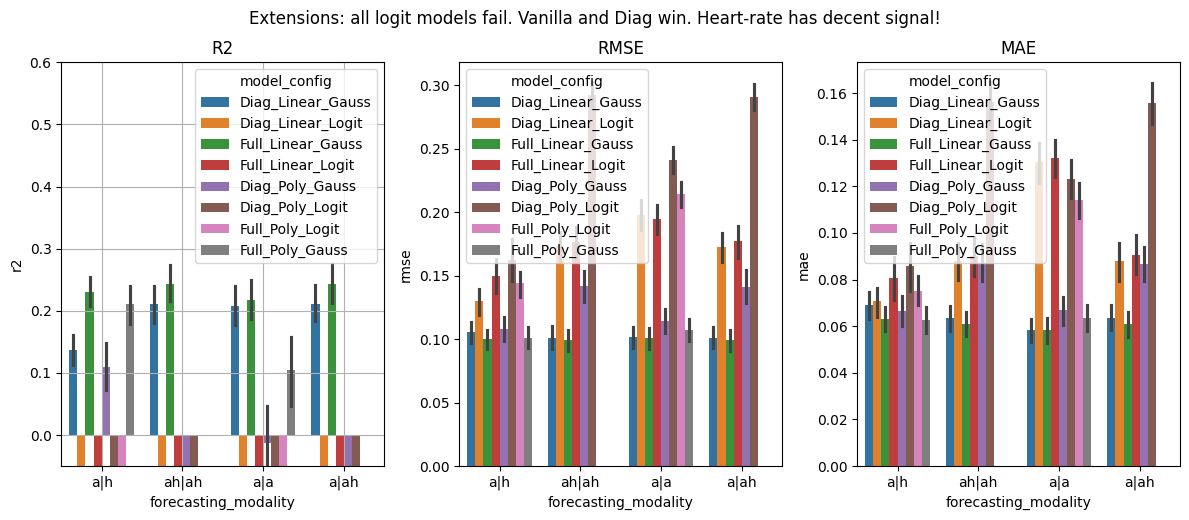

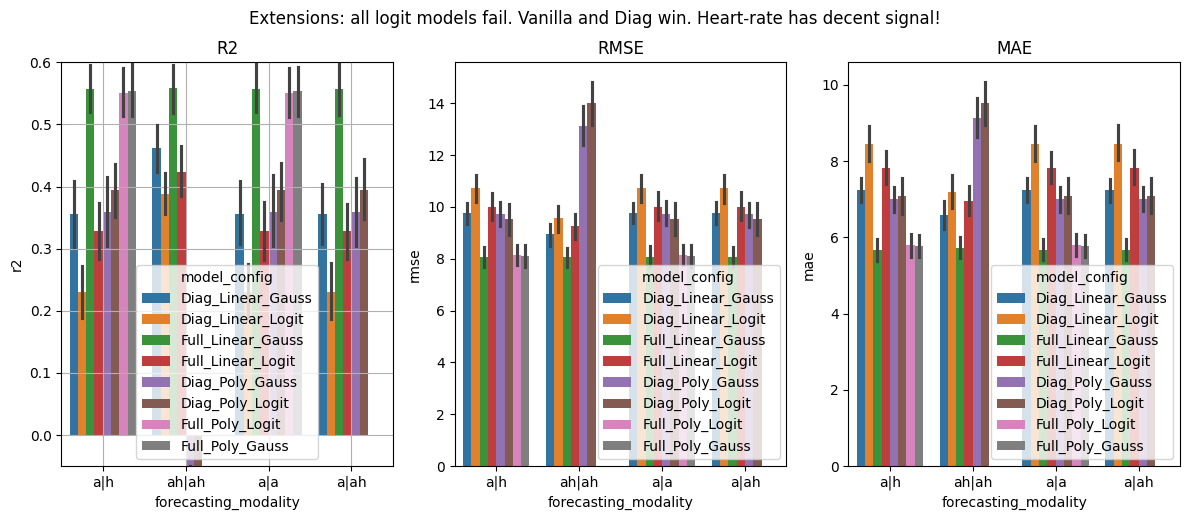

(None, None)

In [112]:
# now that we have the best model
f,axs=explorer.plot_comparison(
        x='forecasting_modality',
        hue='model_config',
        fixed_conditions={'field':'cross', 'initial_uncertainty':4, 'T_eff':10, 'condition':'all',
                          'kernel_hour': 10, 'kernel_day':3,'task':'activity'}
)
f.suptitle('Extensions: all logit models fail. Vanilla and Diag win. Heart-rate has decent signal!', y=1.03)
axs[0].set_ylim([-0.05,0.6])
axs[0].grid()
plt.show(), plt.close()

# now that we have the best model
f,axs=explorer.plot_comparison(
        x='forecasting_modality',
        hue='model_config',
        fixed_conditions={'field':'cross', 'initial_uncertainty':4, 'T_eff':10, 'condition':'all',
                          'kernel_hour': 10, 'kernel_day':3,'task':'heart'}
)
f.suptitle('Extensions: all logit models fail. Vanilla and Diag win. Heart-rate has decent signal!', y=1.03)
axs[0].set_ylim([-0.05,0.6])
axs[0].grid()
plt.show(), plt.close()

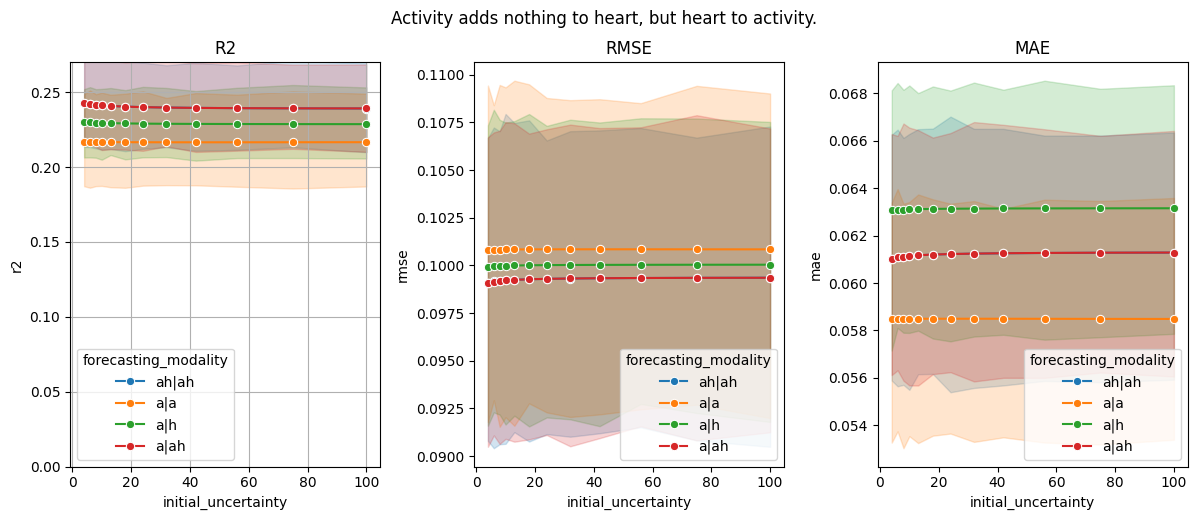

(None, None)

In [55]:
f,axs=explorer.plot_lines(
        x='initial_uncertainty',
        hue='forecasting_modality',
        fixed_conditions={'field':'cross', 'T_eff':10, 'condition':'all', 'model_config':'Full_Linear_Gauss',
                          'kernel_hour': 10, 'kernel_day':3,'task':'activity'}
)
f.suptitle('Activity adds nothing to heart, but heart to activity. More alpha might help.', y=1.03)
axs[0].set_ylim([0,0.27])
axs[0].grid()
plt.show(), plt.close()

### Experiment 3. Kernel Sizes

In [256]:
explorer = init('20251117_1442')

In [257]:
explorer.print_unique_values()

task (2): ['activity', 'heart']
condition (3): ['all', 'sleep_false', 'sleep_true']
rmse: 230901 unique values
mae: 231617 unique values
r2: 232892 unique values
corr: 233349 unique values
n: 57 unique values
path_x: 3302 unique values
run: 3302 unique values
pid (19): [4, 9, 18, 19, 25, 43, 44, 45, 50, 52, 81, 91, 104, 108, 109, 125, 138, 153, 156]
model_name (1): ['rls']
field (4): ['block', 'cross', 'day', 'hour']
diagonal_covariance (2): [False, True]
use_polynomial (1): [False]
use_logit_space (1): [False]
lambda_forget (2): [0.99584200184511, 0.9989588756797244]
initial_uncertainty (1): [5.0]
kernel_day (7): [1, 2, 3, 4, 5, 7, 10]
n_kernel_recent (10): [1, 2, 3, 4, 6, 8, 10, 12, 16, 20]
kernel_hour (10): [1.0, 2.0, 3.0, 4.0, 6.0, 8.0, 10.0, 12.0, 16.0, 20.0]
n_pars_activity: 177 unique values
n_pars_heart: 117 unique values
dt (1): [60]
prediction_horizon (1): [60]
n_forward (1): [1]
prediction_index (1): [0]
forecasting_modality (3): ['a|a', 'a|ah', 'a|h']
burn_in_days (1): [40]

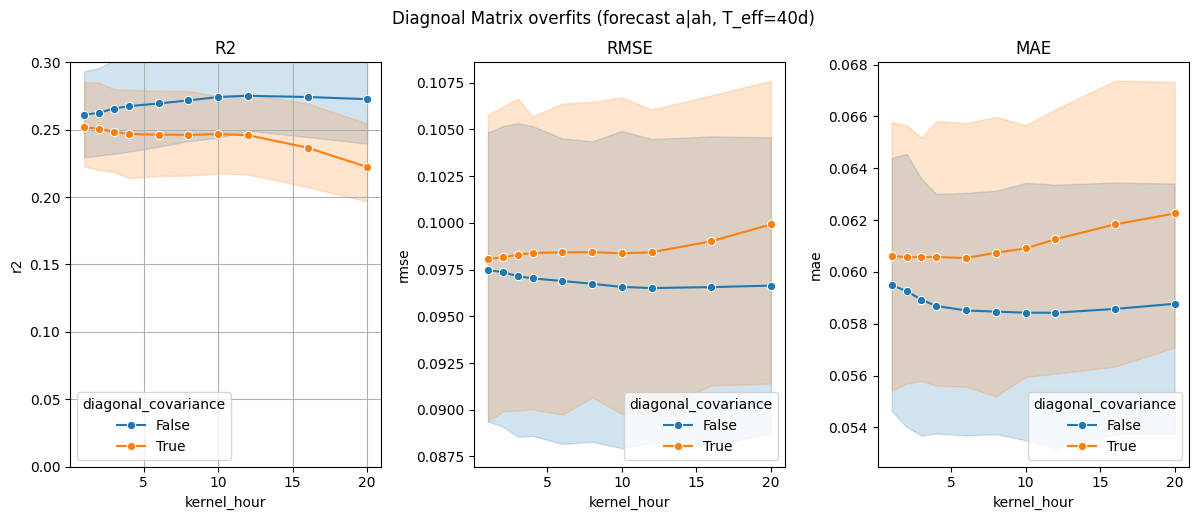

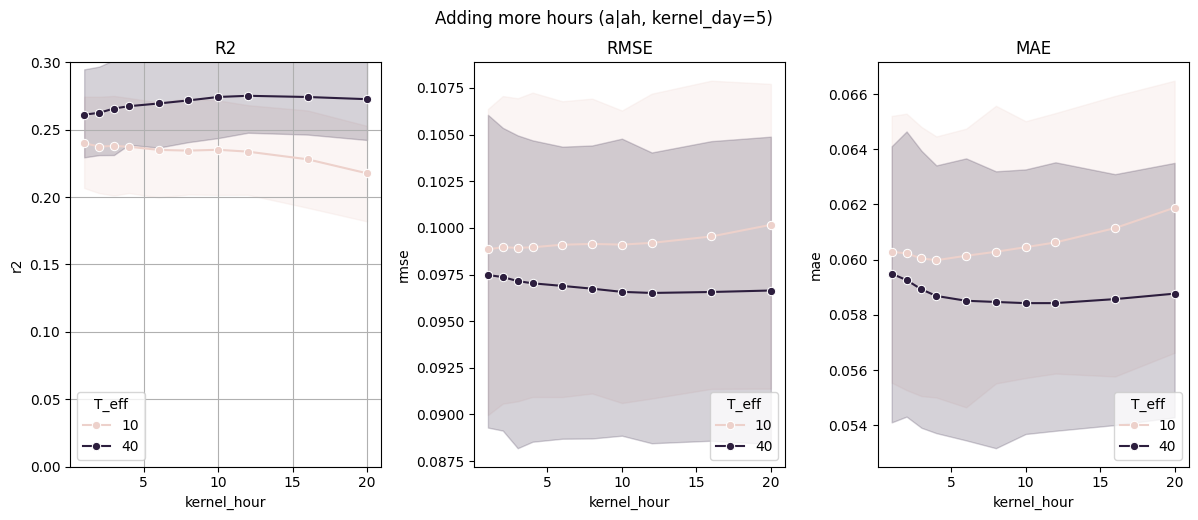

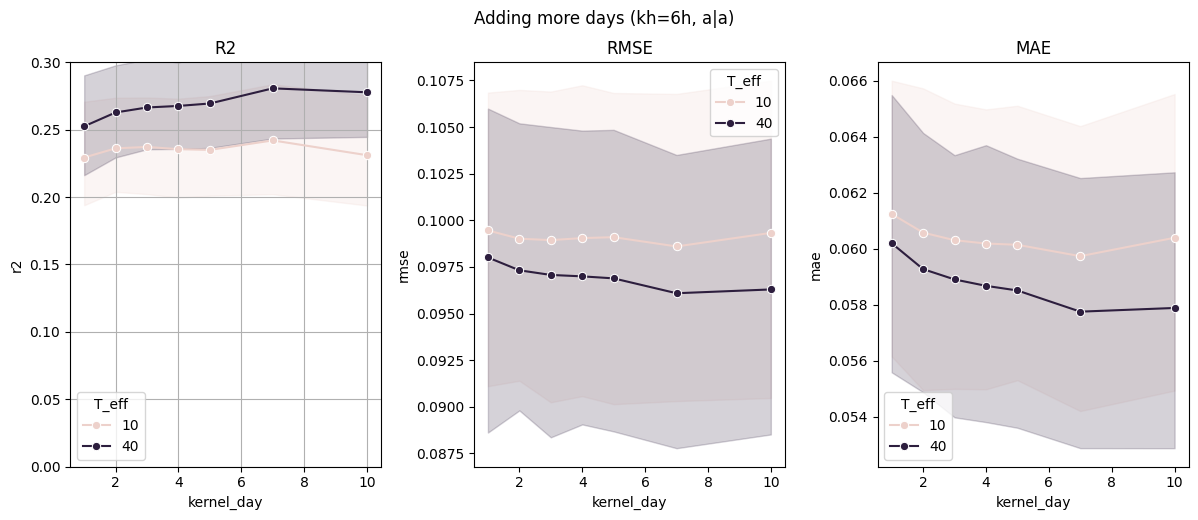

(None, None)

In [279]:
f,axs=explorer.plot_lines(
        x='kernel_hour',
        hue='diagonal_covariance',
        #hue='forecasting_modality', # T_eff',
        fixed_conditions={'field':'cross', 
                          'condition':'all',
                          #'diagonal_covariance':False, #'model_config':'Full_Linear_Gauss',
                          'task':'activity', 
                          'kernel_day':5 ,
                          'initial_uncertainty':5, 
                          'T_eff':40,
                          'forecasting_modality':'a|ah'
                         }
)
f.suptitle('Diagnoal Matrix overfits (forecast a|ah, T_eff=40d)', y=1.03)
axs[0].set_ylim([0,0.3])
axs[0].grid()
plt.show(), plt.close()

#### 
f,axs=explorer.plot_lines(
        x='kernel_hour',
        #hue='forecasting_modality',        
        hue='T_eff',
        fixed_conditions={'field':'cross',
                          'condition':'all',                          
                          'diagonal_covariance':False, #'model_config':'Full_Linear_Gauss',
                          'task':'activity', 
                          'kernel_day':5 ,
                          'initial_uncertainty':5, 
                          #'T_eff':40,
                          'forecasting_modality':'a|ah'
                         }
)
f.suptitle('Adding more hours (a|ah, kernel_day=5)', y=1.03)
axs[0].set_ylim([0,0.3])
axs[0].grid()
plt.show(), plt.close()

f,axs=explorer.plot_lines(
        x='kernel_day',        
        hue='T_eff', # T_eff',
        fixed_conditions={'field':'cross', 
                          'condition':'all',
                          'diagonal_covariance':False, #'model_config':'Full_Linear_Gauss',
                          'task':'activity','kernel_hour':6 , 'initial_uncertainty':5, #'T_eff':10,
                          'forecasting_modality':'a|ah'}
)
f.suptitle('Adding more days (kh=6h, a|a)', y=1.03)
axs[0].set_ylim([0,0.3])
axs[0].grid()
plt.show(), plt.close()

##### Now check kernels for various modalities

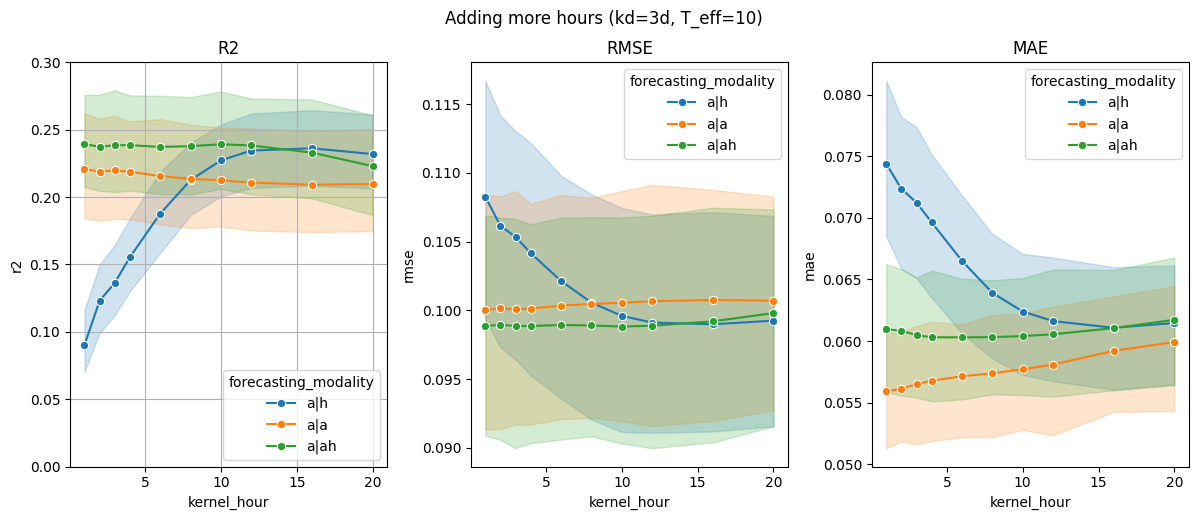

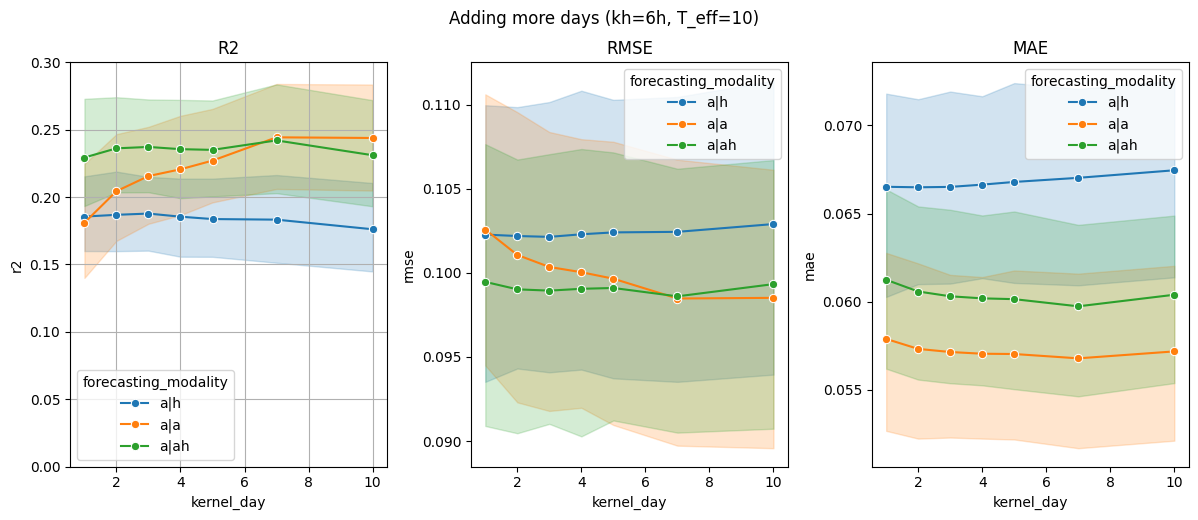

(None, None)

In [281]:
### 
f,axs=explorer.plot_lines(
        x='kernel_hour',        
        hue='forecasting_modality', # T_eff',
        fixed_conditions={'field':'cross', 
                          'condition':'all',
                          'diagonal_covariance':False, #'model_config':'Full_Linear_Gauss',
                          'task':'activity','kernel_day':3 , 'initial_uncertainty':5, 'T_eff':10,
                          #'forecasting_modality':'a|ah'
                         }
)
f.suptitle('Adding more hours (kd=3d, T_eff=10)', y=1.03)
axs[0].set_ylim([0,0.3])
axs[0].grid()
plt.show(), plt.close()



### 
f,axs=explorer.plot_lines(
        x='kernel_day',        
        hue='forecasting_modality', # T_eff',
        fixed_conditions={'field':'cross', 
                          'condition':'all',
                          'diagonal_covariance':False, #'model_config':'Full_Linear_Gauss',
                          'task':'activity','kernel_hour':6 , 'initial_uncertainty':5, 'T_eff':10,
                          #'forecasting_modality':'a|ah'
                         }
)
f.suptitle('Adding more days (kh=6h, T_eff=10)', y=1.03)
axs[0].set_ylim([0,0.3])
axs[0].grid()
plt.show(), plt.close()



## 4. What about AUC performance?

1. consider case
    1. calib
    2. rest
3. control

In [54]:
from run_config import PATIENT_COHORTS

def init(run, classification=False):
    """ factory funct 

    Use: pid to construct cohort
    
    """
    
    runs_path =  Path(f'/sc/arion/projects/Clinical_Times_Series/cpp_data/runs/{run}/')
    table_path = runs_path / 'results'
    
    meta = pd.read_csv(table_path / 'metadata.csv')
    if classification:
        data = pd.read_csv(table_path / 'classification_auc.csv')
        metrics = ['roc_auc','pr_auc', 'balance']
    else:            
        data = pd.read_csv(table_path / 'regression.csv')
        metrics = None # use default
        
    # time window in days
    meta['T_eff'] = np.round(-meta['dt']/np.log(meta['lambda_forget']) / (24*60)).astype(int) # convert to days

    if np.all(meta['cohort'] == 'case'):
        meta['calibration'] = meta['pid'].isin(PATIENT_COHORTS['calibration'])
    
    # compute tot pars
    h_flag = ~meta['forecasting_modality'].isin(['a|a'])
    a_flag = ~meta['forecasting_modality'].isin(['a|h'])
    meta['pars_tot'] = meta['n_pars_heart']*h_flag + meta['n_pars_activity']*a_flag

    return MetricExplorer(data, meta,metrics=metrics)

run = '20251118_1806'
explorer = init(run, classification=True)

In [55]:
explorer.print_unique_values()

target (3): ['absent_sedentary', 'mvpa', 'sedentary_bout']
condition (3): ['all', 'sleep_false', 'sleep_true']
roc_auc: 184908 unique values
pr_auc: 243332 unique values
n: 355 unique values
balance: 1068 unique values
path_x: 286 unique values
run: 286 unique values
pid: 134 unique values
model_name (1): ['rls']
field (4): ['block', 'cross', 'day', 'hour']
diagonal_covariance (2): [False, True]
use_polynomial (1): [False]
use_logit_space (1): [False]
lambda_forget (2): [0.99584200184511, 0.9989588756797244]
initial_uncertainty (1): [5.0]
kernel_day (2): [1, 5]
n_kernel_recent (3): [1, 5, 10]
kernel_hour (3): [1.0, 5.0, 10.0]
n_pars_activity: 31 unique values
n_pars_heart (17): [3, 5, 7, 11, 13, 21, 23, 31, 43, 71, 111, 131, 133, 241, 463, 1261, 4291]
dt (1): [60]
prediction_horizon (1): [60]
n_forward (1): [1]
prediction_index (1): [0]
forecasting_modality (3): ['a|a', 'a|ah', 'a|h']
min_days (1): [20]
burn_in_days (1): [10]
valid_days: 129 unique values
nan_days: 129 unique values
to

In [31]:
processed_path = '/sc/arion/projects/Clinical_Times_Series/cpp_data/final/processed/ctrl/revision_nan_all_patients_60.npz'
loaded = np.load(processed_path, allow_pickle=True)
metadata = pd.DataFrame.from_records(loaded['metadata'])
len(metadata.patient_count.unique())

71

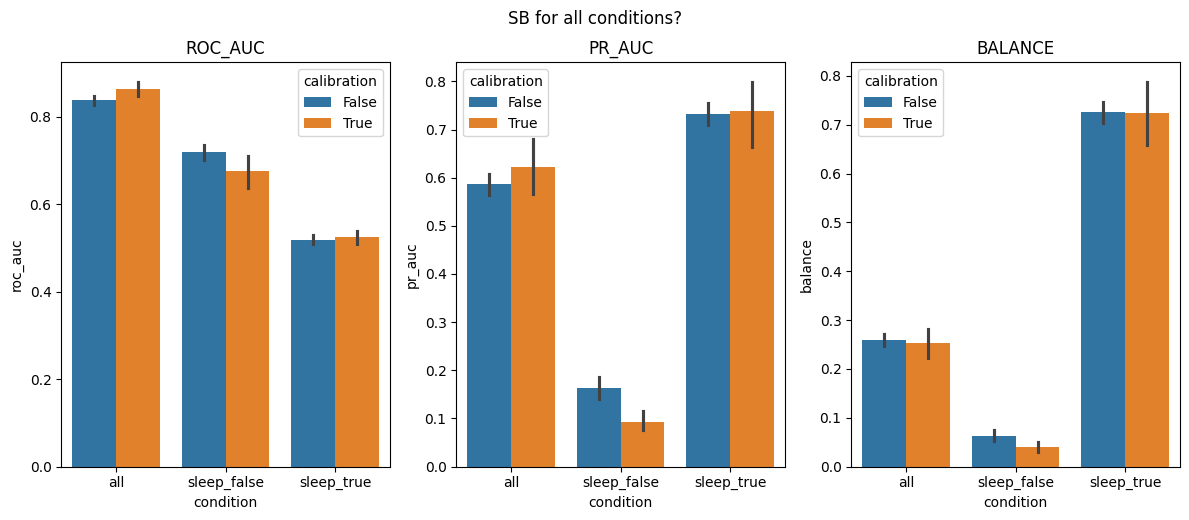

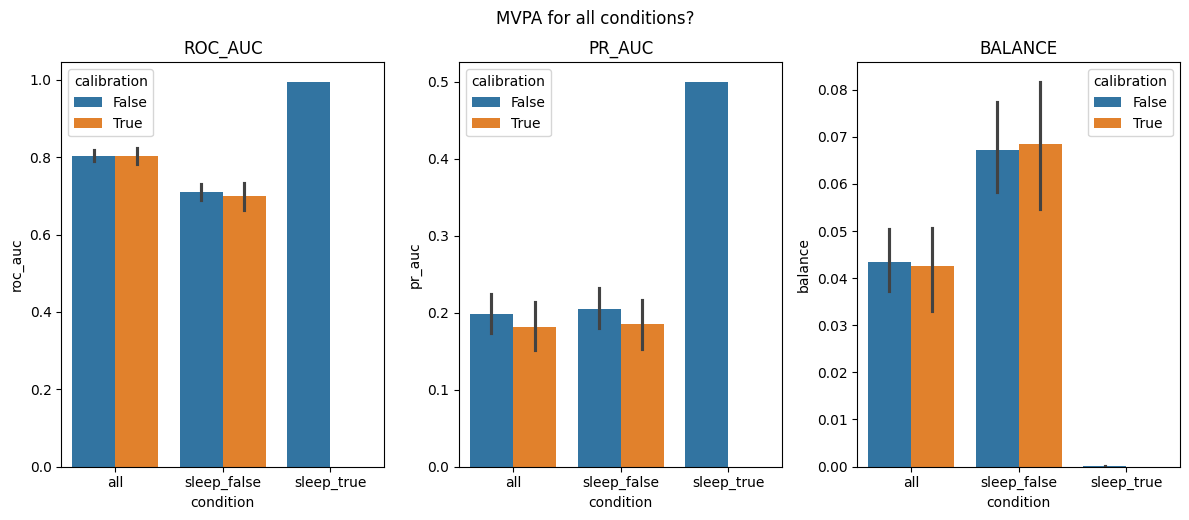

(None, None)

In [64]:
fixed_conditions={'field':'cross', 'diagonal_covariance':False, #'task':'activity',
                          'kernel_hour': 10, 'kernel_day':5,'target':'sedentary_bout', 'T_eff':10} # 
fixed_conditions.update({'forecasting_modality':'a|a'})

# now that we have the best model
f,axs=explorer.plot_comparison(
        hue='calibration',
        x='condition',
        fixed_conditions=fixed_conditions)
f.suptitle('SB for all conditions?', y=1.03)
plt.show(), plt.close()

# now that we have the best model
fixed_conditions.update({'target':'mvpa'})
f,axs=explorer.plot_comparison(
        hue='calibration',
        x='condition',
        fixed_conditions=fixed_conditions)

f.suptitle('MVPA for all conditions?', y=1.03)
plt.show(), plt.close()

#### IS the best model still the best?

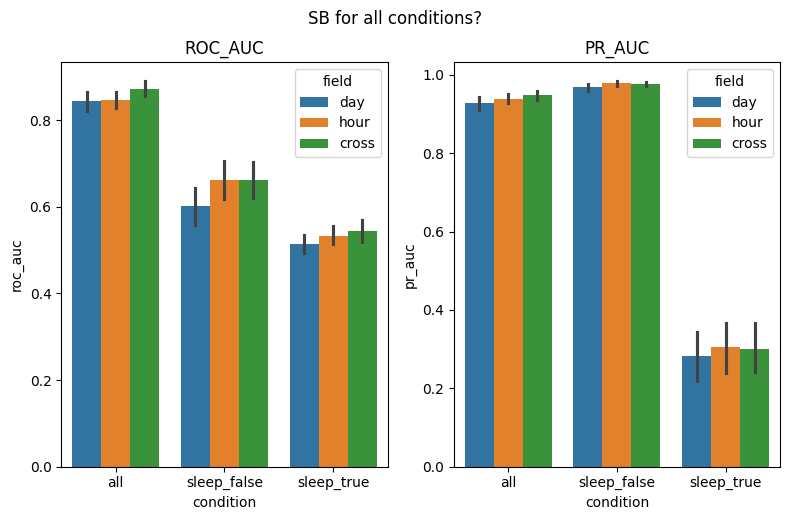

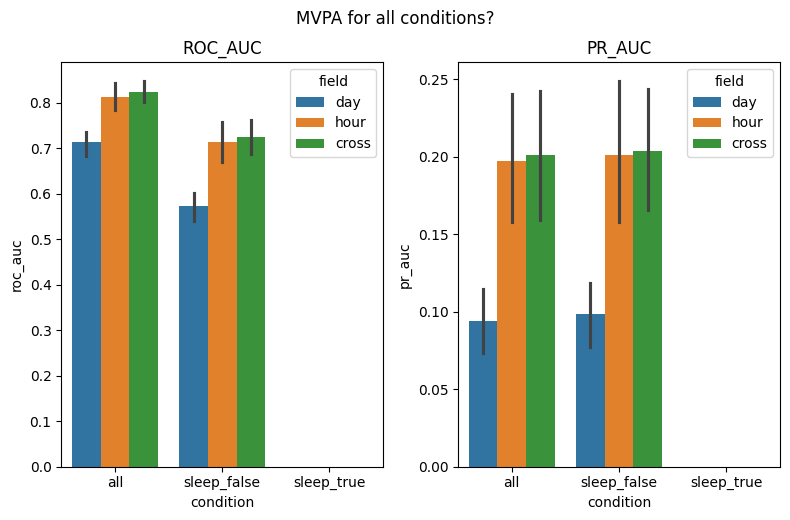

(None, None)

In [18]:
# now that we have the best model
f,axs=explorer.plot_comparison(
        hue='field',
        x='condition',
        fixed_conditions={'T_eff':40, 'forecasting_modality':'a|ah', 'diagonal_covariance':False, #'task':'activity',
                          'kernel_hour': 10, 'kernel_day':5,'target':'absent_sedentary'}
)
f.suptitle('SB for all conditions?', y=1.03)
plt.show(), plt.close()

# now that we have the best model
f,axs=explorer.plot_comparison(
        hue='field',
        x='condition',
        fixed_conditions={'T_eff':40, 'forecasting_modality':'a|ah', 'diagonal_covariance':False, #'task':'activity',
                          'kernel_hour': 10, 'kernel_day':5,'target':'mvpa'}
)
f.suptitle('MVPA for all conditions?', y=1.03)
plt.show(), plt.close()

## 4.b Controls. Same as Case.

In [65]:
run = '20251118_1801'
explorer = init(run, classification=True)

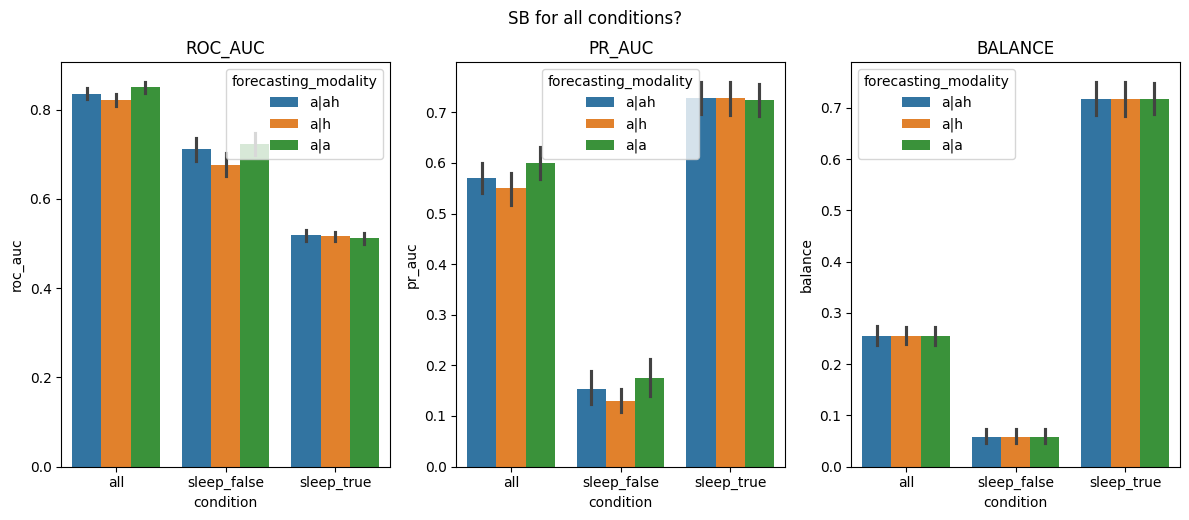

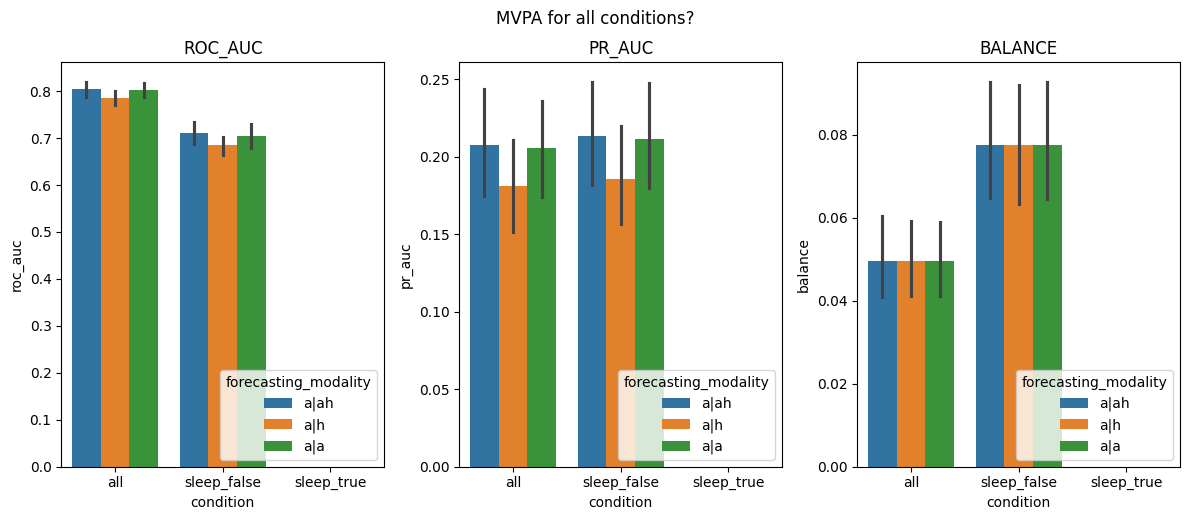

(None, None)

In [68]:
fixed_conditions={'field':'cross', 'diagonal_covariance':False, #'task':'activity',
                          'kernel_hour': 10, 'kernel_day':5,'target':'sedentary_bout','T_eff':10} # 
#fixed_conditions.update({'forecasting_modality':'a|a'})

# now that we have the best model
f,axs=explorer.plot_comparison(
        hue='forecasting_modality',
        x='condition',
        fixed_conditions=fixed_conditions)
f.suptitle('SB for all conditions?', y=1.03)
plt.show(), plt.close()

# now that we have the best model
fixed_conditions.update({'target':'mvpa'})
f,axs=explorer.plot_comparison(
        hue='forecasting_modality',
        x='condition',
        fixed_conditions=fixed_conditions)

f.suptitle('MVPA for all conditions?', y=1.03)
plt.show(), plt.close()

## Discussion: we're doing better than baseline. But not by a lot.

What are my option?
1. shorten $dt$
2. beat baseline models

# 3. Parameter number

In [33]:
from utils import count_pars
count_pars(modality=['ah|ah','ah|h','a|a','a|h'][1], days=3, hours=9, field='cross', poly_feat=False, time_res=60, horizon=60, diag=True)

62.0

# 2. Cohort statistics

In [2]:
RESULTS_PATH = "/sc/arion/work/jegmij01/patchtst/datasets/private/cpp/"
window = 60
#df = pd.read_csv(f"{RESULTS_PATH}/final_img_activity_{window}.csv")
df = pd.read_csv(f"{RESULTS_PATH}/final_nan_img_activity_{window}.csv")

### Data overview, including missing values

- trim
- demand minimal training data of non-missing 10 days and 10 days evaluation

In [51]:
sorted([59,3,80,7,5,60,13,16,42])

[3, 5, 7, 13, 16, 42, 59, 60, 80]

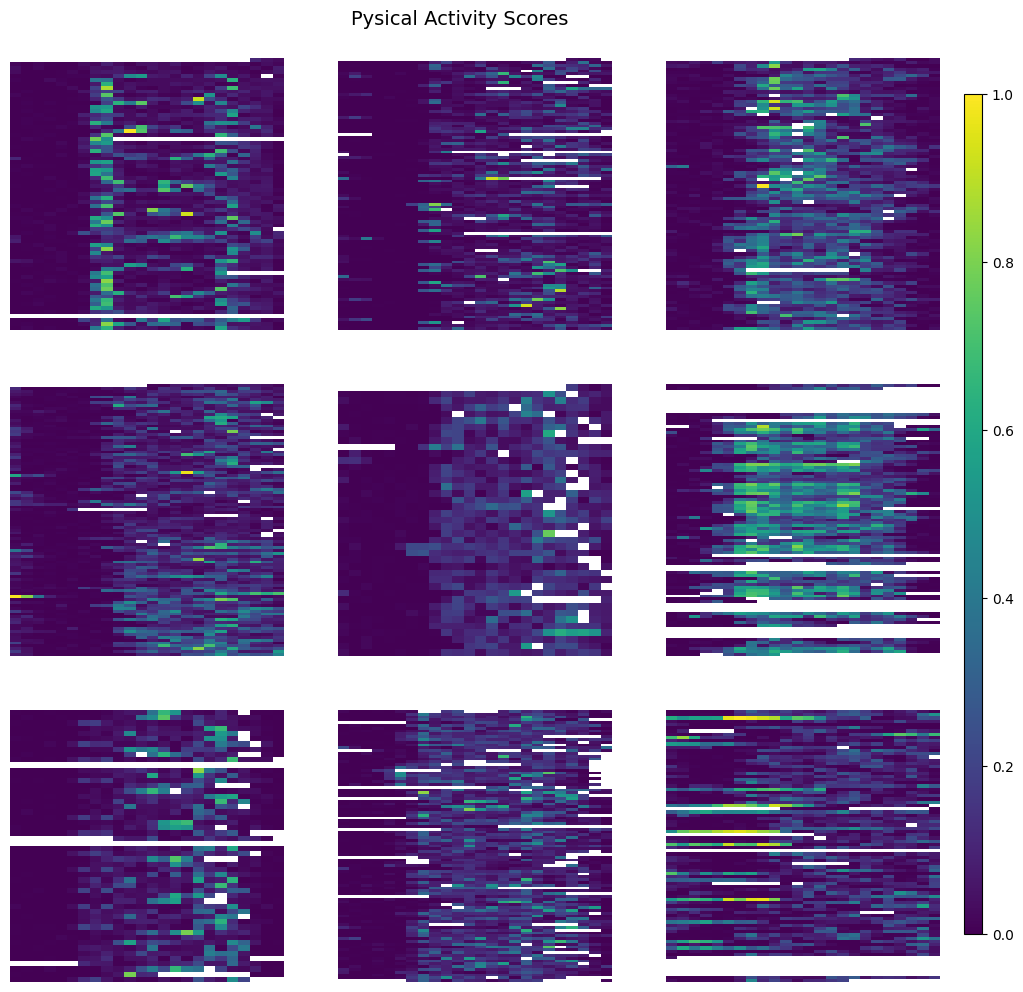

In [52]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import math

n_plots = 9
#ordering = np.arange(100)
# Unique patient IDs and count
patient_ids = df.patient_count.unique()[[59,3,80,7,5,60,13,16,42]] #[:n_plots]
n_patients = len(patient_ids)

# Define subplot grid size
n_cols = 3
n_rows = math.ceil(n_patients / n_cols)

# Create subplots
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 4, n_rows * 4)) # tight_layout=True)
axes = axes.flatten()

# Custom colormap: handle NaNs as gray
cmap = plt.cm.viridis.copy()
cmap.set_bad(color='white')

# Keep track of valid patients for later use
good_patients = []

norm = mcolors.Normalize(vmin=0, vmax=1)

# Loop through patients
for i, pid in enumerate(patient_ids):
    # Extract and preprocess values
    val = df.set_index('patient_count').loc[pid].iloc[:, 1:].values
    val = trim_nan_rows(val.copy())
    val_days = np.sum(~np.isnan(val)) / 24  # Assuming 24 time points per day

    good_patients.append({'pid': pid, 'val_days': val_days})

    # Show with imshow, auto aspect ratio
    im = axes[i].imshow(val, aspect='auto', cmap=cmap, interpolation='none', norm=norm)

    # Titles
    #axes[i].set_title(f'ID {pid}\nValid Days {val_days:.1f}/{val.size/24:.0f}', fontsize=8)
    axes[i].axis('off')

    #if i == 7:
     #   axes[i].set_xlabel('Hour')
      #  axes[i].set_ylabel('Day')

# Hide any unused axes
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

# Add colorbar — place outside the grid
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])  # [left, bottom, width, height]

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
#sm.set_array([])
cbar = plt.colorbar(sm, cax=cbar_ax)
#cbar.set_label('Physical Activity Score', rotation=270, labelpad=15)

# Overall layout
#plt.suptitle(f'Activity Patterns Across First {n_plots} Participants', fontsize=14, y=0.92)
plt.suptitle(f'Pysical Activity Scores', fontsize=14, y=0.92)
#plt.subplots_adjust(left=0.05, right=0.9, top=0.92, bottom=0.05, wspace=0.4, hspace=0.6)
plt.show()
fig.savefig(f"figures/activity_across_{n_plots}_participants.jpg", dpi=300, bbox_inches='tight')

In [14]:
def count(bin_matrix, min_samples=20):
    return (bin_matrix.sum().sum() >= min_samples) and ((bin_matrix==False).sum().sum() >= min_samples)        

print('using heart rate filter', len(df.patient_count.unique()), len(df))

idx = df.isna().mean(axis=1) < 0.7
print('using >70%:', len(df[idx].patient_count.unique()), len(df[idx]))

def get_bal(df):
    good_patients = []
    hist = []
    
    for patient_id in df.patient_count.unique():
        patient_data = df[df.patient_count == patient_id]
         
        pos_count = (patient_data.iloc[:, 2:] == 0).sum().sum()
        neg_count = (patient_data.iloc[:, 2:] > 0).sum().sum()
        missing = patient_data.iloc[:, 2:].isna().sum().sum()
        total = patient_data.iloc[:, 2:].size
    
        # Check if all classes have at least 20 samples
        good = (pos_count >= 20) and (neg_count >= 20)
        if good:
            good_patients.append(patient_id)

        hist.append({'patient_id':patient_id, 'positive':pos_count, 
                     'negative':neg_count, 'balanced':good, 
                     'missing': missing, 'total':total,
                     'days':len(patient_data)})
    
    # Now filter dataframe to these patients
    df_good = df[df.patient_count.isin(good_patients)]
    
    patients = len(good_patients)
    days = len(df_good)
    
    print('At least 20 of each class:', patients, 'patients and', days, 'days')
    return pd.DataFrame(hist)

stats = get_bal(df[idx])

using heart rate filter 150 8362
using >70%: 148 8004
At least 20 of each class: 142 patients and 7993 days


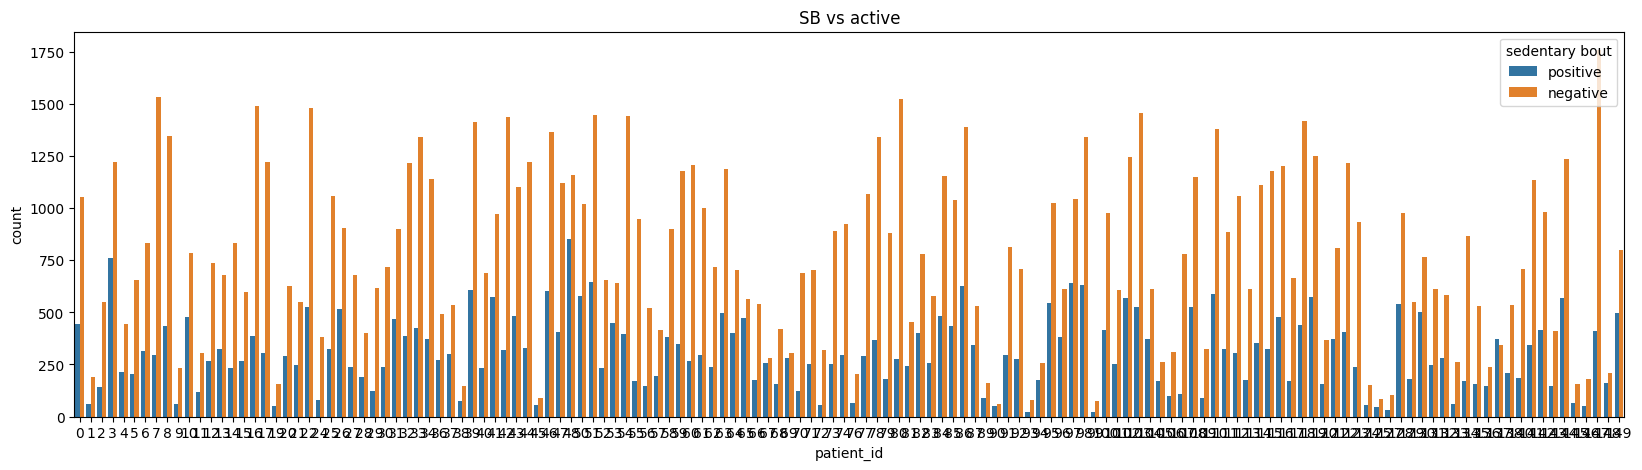

In [15]:
import seaborn as sns
melted = stats.melt(
    id_vars=['patient_id', 'balanced', 'days', 'missing', 'total'],  # columns to keep
    value_vars=['positive', 'negative'], # columns to melt
    var_name='sedentary bout',                    # name of the new column for 'positive'/'negative'
    value_name='count'                   # name of the new column for the counts
)
plt.figure(figsize=[20,5])
plt.title('SB vs active')
sns.barplot(melted[melted.balanced==True], x='patient_id', y='count', hue='sedentary bout')
plt.show()

<Axes: title={'center': 'SB vs active'}, xlabel='patient_id', ylabel='days'>

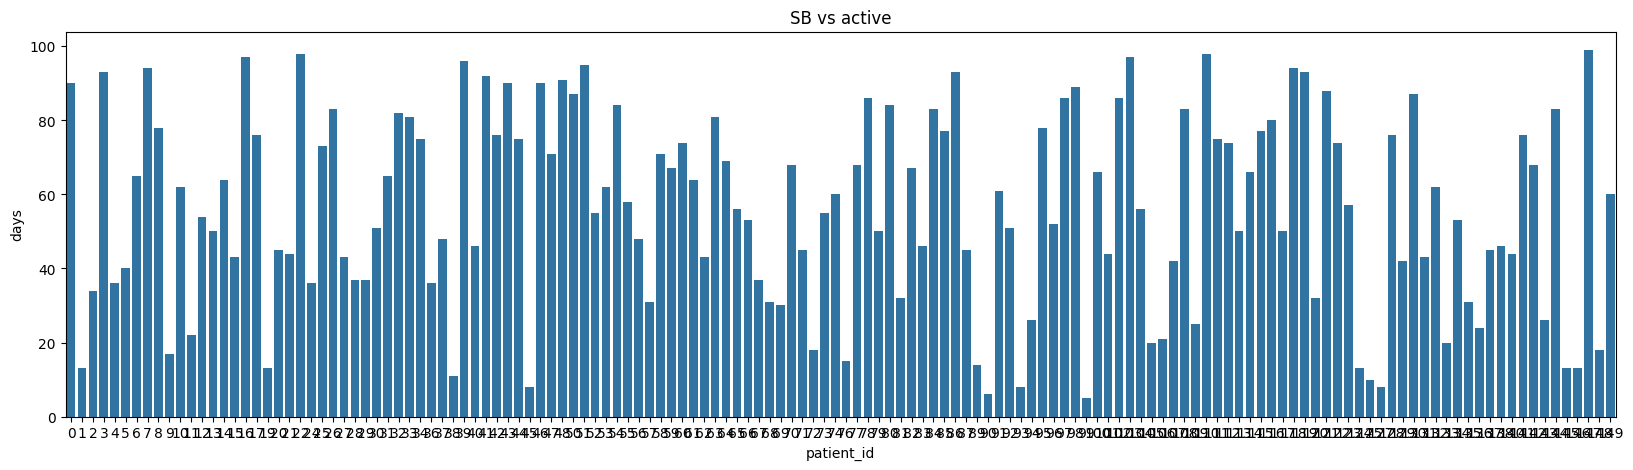

In [10]:
plt.figure(figsize=[20,5])
plt.title('SB vs active')
sns.barplot(melted[melted.balanced==True], x='patient_id', y='days')

In [24]:
good_sum = stats[stats.balanced==True].sum()
good_sum['missing']/good_sum['total'], good_sum['total']

(0.19313774552733642, 191832.0)

<Axes: xlabel='patient_id', ylabel='days'>

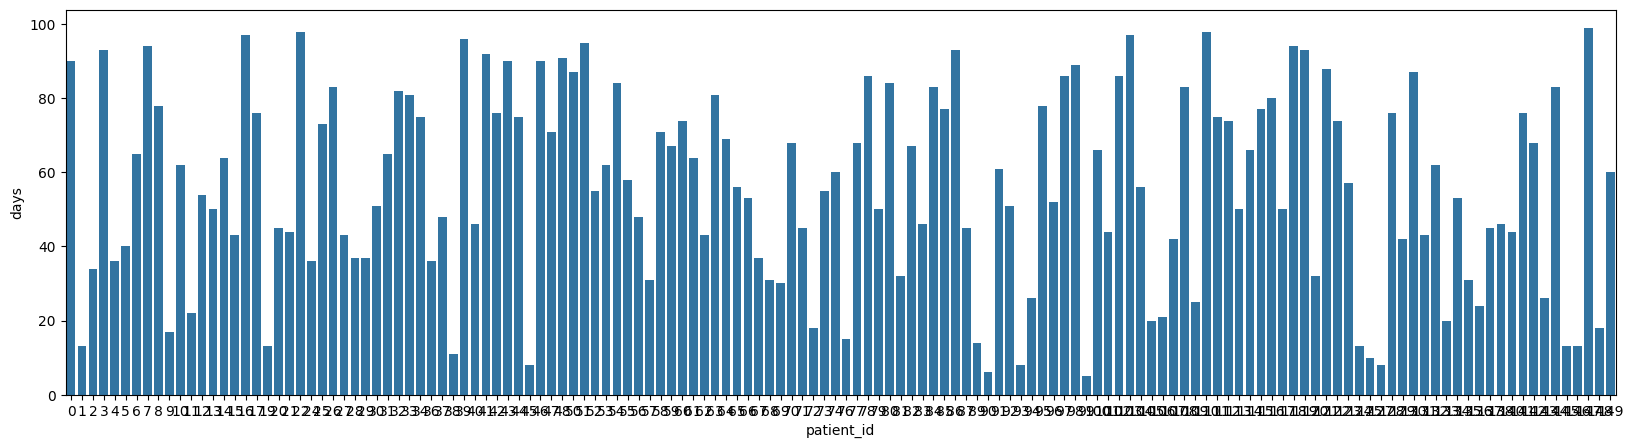

In [29]:
plt.figure(figsize=[20,5])

#plt.title('SB vs active')
sns.barplot(melted[melted.balanced==True], x='patient_id', y='days')
#melted[melted.balanced==True].days.min()

Text(0.5, 1.0, 'Ratio of missing values across patients')

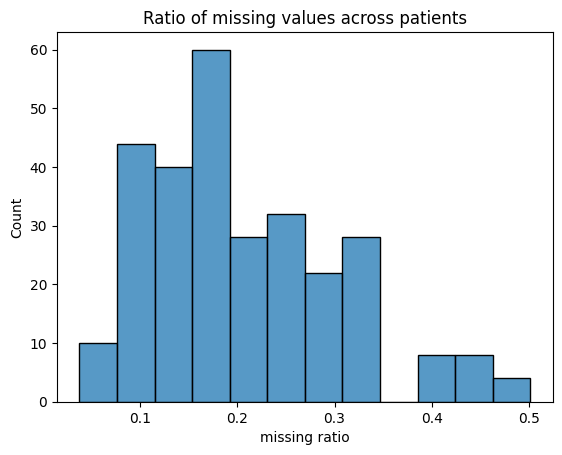

In [32]:
melted['missing ratio'] = melted['missing']/melted['total']
sns.histplot(melted[melted.balanced==True], x='missing ratio')
plt.title('Ratio of missing values across patients')

In [37]:
melted[melted.balanced==True]['missing ratio'].sort_values()

42     0.037829
190    0.037829
156    0.049145
8      0.049145
207    0.050373
         ...   
124    0.462500
172    0.465278
24     0.465278
70     0.501225
218    0.501225
Name: missing ratio, Length: 284, dtype: float64

# 3. Input space visualization:

/tmp/ipykernel_1815031/2264513238.py:14: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  plt.colorbar()


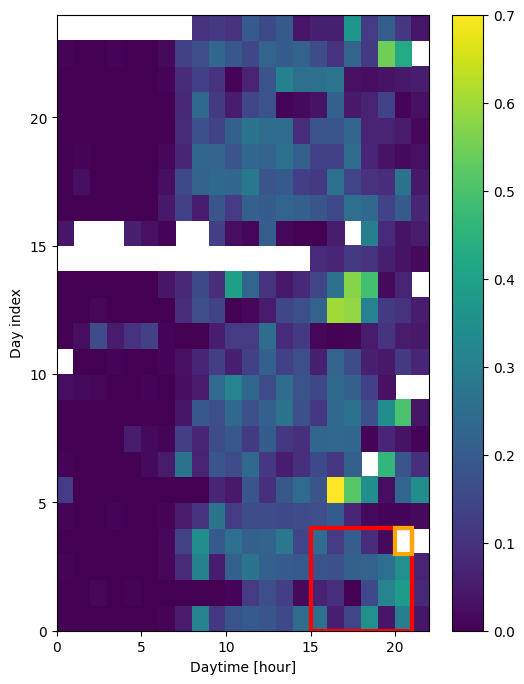

In [ ]:
import matplotlib.patches as patches

RESULTS_PATH = '/sc/arion/work/jegmij01/patchtst/datasets/private/cpp/'
df = pd.read_csv(RESULTS_PATH + 'final_img_activity_60.csv')
#plt.plot(df.iloc[:,2:].isna().mean(axis=1).sort_values().iloc[::-1].values)
#plt.title('ratio of nans per day')
idx = df.isna().mean(axis=1) < 0.7
df = df[idx].iloc[:,2:]
plt.figure(figsize=[6,8])
yy = 503
plt.pcolor(df.iloc[yy:yy+24,2:].values) # ignore index
plt.xlabel('Daytime [hour]')
plt.ylabel('Day index')
plt.colorbar()
t = 15
kh = 5
kd = 3
d = 0
rect = patches.Rectangle((t, d), kh+1, kd+1, linewidth=3, edgecolor='red', facecolor='none')
target = patches.Rectangle((t+kh, d+kd), 1, 1, linewidth=3, edgecolor='orange', facecolor='none')
# Add the rectangle to the plot
plt.gca().add_patch(rect)
plt.gca().add_patch(target)

### Inductive biases:

/tmp/ipykernel_1815031/1168086088.py:54: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  fig.colorbar(im, cax=cbar_ax)
/tmp/ipykernel_1815031/1168086088.py:56: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar on right


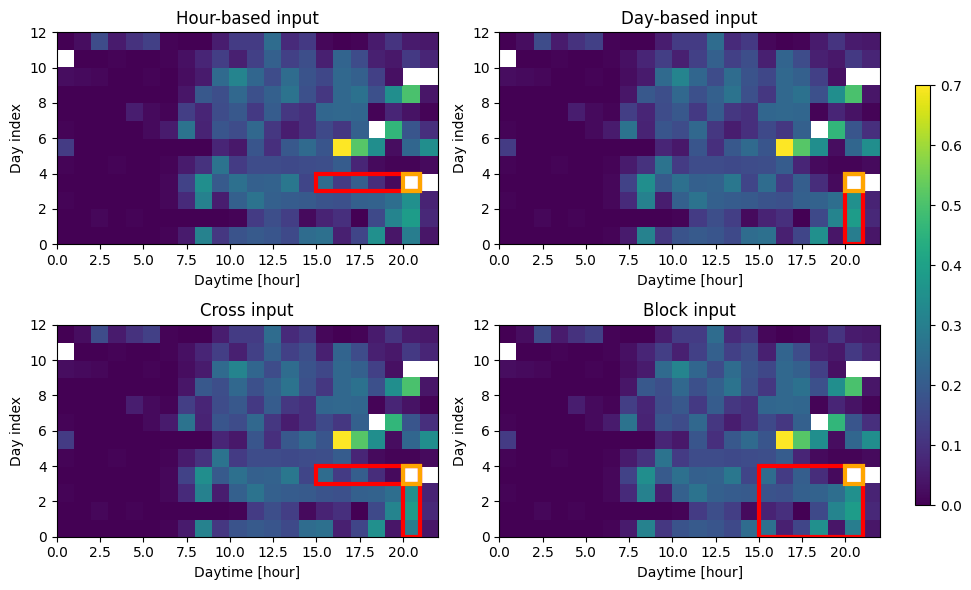

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Load data
RESULTS_PATH = '/sc/arion/work/jegmij01/patchtst/datasets/private/cpp/'
df = pd.read_csv(RESULTS_PATH + 'final_img_activity_60.csv')

# Filter and slice
idx = df.isna().mean(axis=1) < 0.7
df = df[idx].iloc[:, 2:]

# Set plot parameters
yy = 503
height = 12
data = df.iloc[yy:yy+height, 2:].values

# Rectangle parameters
t = 15
kh = 5
kd = 3
d = 0

# Create subplots
fig, axes = plt.subplots(2, 2, figsize=(10, 6))

for i, ax in enumerate(axes.flat):
    im = ax.pcolor(data)
    ax.set_xlabel('Daytime [hour]')
    ax.set_ylabel('Day index')

    # Add patches
    if i == 0:
        rect = patches.Rectangle((t, d+kd), kh+1, 1, linewidth=3, edgecolor='red', facecolor='none')
        ax.set_title('Hour-based input')
    elif i == 1:
        rect = patches.Rectangle((t+kh, d), 1, kd+1, linewidth=3, edgecolor='red', facecolor='none')        
        ax.set_title('Day-based input')
    elif i == 2:
        rect = patches.Rectangle((t+kh, d), 1, kd+1, linewidth=3, edgecolor='red', facecolor='none')
        ax.add_patch(rect)
        rect = patches.Rectangle((t, d+kd), kh+1, 1, linewidth=3, edgecolor='red', facecolor='none')
        ax.set_title('Cross input')
    elif i == 3:
        rect = patches.Rectangle((t, d), kh+1, kd+1, linewidth=3, edgecolor='red', facecolor='none')
        ax.set_title('Block input')
    ax.add_patch(rect)

    target = patches.Rectangle((t+kh, d+kd), 1, 1, linewidth=3, edgecolor='orange', facecolor='none')
    ax.add_patch(target)

# Add colorbar to the right side
cbar_ax = fig.add_axes([0.92, 0.15, 0.015, 0.7])  # [left, bottom, width, height]
fig.colorbar(im, cax=cbar_ax)

plt.tight_layout(rect=[0, 0, 0.9, 1])  # leave space for colorbar on right
plt.show()

### Visualize processed all data

In [ ]:
# width = 16.5 inch * 300 ≈ 4950 px
# height = 23.4 inch * 300 ≈ 7020 px
RESULTS_PATH = '/sc/arion/work/jegmij01/patchtst/datasets/private/cpp/'
df = pd.read_csv(RESULTS_PATH + 'final_img_hr_1.csv').iloc[:,2:]
fig, ax = plt.subplots(figsize=(16.5, 23.4), dpi=300)  # A2 size
c = ax.pcolor(df.values, cmap='viridis')  # use an aesthetic colormap
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)
plt.axis('off')  # completely removes axes
plt.tight_layout(pad=0)
plt.savefig("hr_art.png", bbox_inches='tight', pad_inches=0)
plt.show(), plt.close()

RESULTS_PATH = '/sc/arion/work/jegmij01/patchtst/datasets/private/cpp/'
df = pd.read_csv(RESULTS_PATH + 'final_img_activity_1.csv').iloc[:,2:]
fig, ax = plt.subplots(figsize=(16.5, 23.4), dpi=300)  # A2 size
c = ax.pcolor(df.values, cmap='viridis')  # use an aesthetic colormap
ax.set_xticks([])
ax.set_yticks([])
ax.set_frame_on(False)
plt.axis('off')  # completely removes axes
plt.tight_layout(pad=0)
plt.savefig("activity_art.png", bbox_inches='tight', pad_inches=0)

In [ ]:
def pars(dim):    
    print('linear', dim + 1)
    print('poly', int(dim + 1 + dim * (dim-1) / 2))
for dim in [3,5,8, 23]:
    pars(dim)

linear 4
poly 7.0
linear 6
poly 16.0
linear 9
poly 37.0
linear 24
poly 277.0


### Averaging visual

In [71]:
RESULTS_PATH = "/sc/arion/work/jegmij01/patchtst/datasets/private/cpp/"
window = 1
#df = pd.read_csv(f"{RESULTS_PATH}/final_img_activity_{window}.csv")
df = pd.read_csv(f"{RESULTS_PATH}/final_img_activity_{window}.csv")

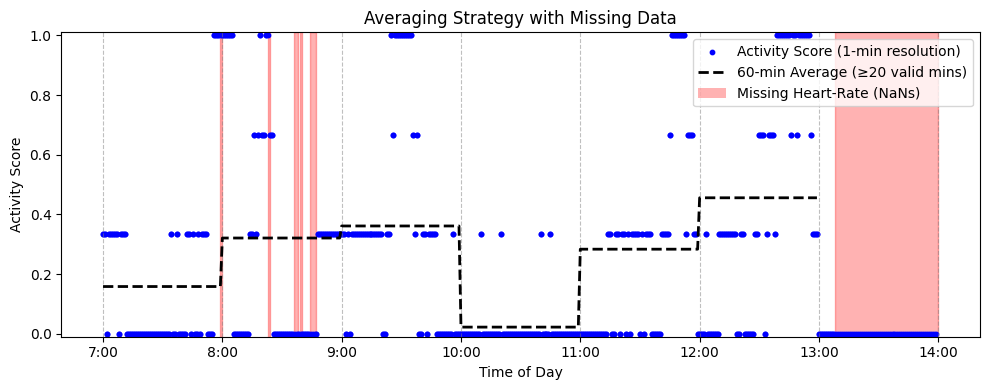

In [77]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch

def mean_nan(y, thres=20):
    """
    Compute the mean of y ignoring NaNs, only if at least `thres` non-NaN values are present.
    """    
    return np.nanmean(y) if np.sum(~np.isnan(y)) >= thres else np.nan

# Extract 7am to 12pm (e.g. 660 to 1080 minutes)
day = 2
arr = df[df.patient_count == 450].iloc[:, 2:].values[day, 660:1080]

# Identify NaN locations
nan_idx = np.isnan(arr)

# Initialize plot
fig, ax = plt.subplots(figsize=(10, 4))

# Plot missing regions as shaded areas
in_nan = False
for i in range(len(nan_idx)):
    if nan_idx[i] and not in_nan:
        start = i
        in_nan = True
    elif not nan_idx[i] and in_nan:
        end = i
        ax.axvspan(start, end, color='red', alpha=0.3)
        in_nan = False
if in_nan:
    ax.axvspan(start, len(nan_idx), color='red', alpha=0.3)

# Plot original activity score
ax.scatter(np.arange(len(arr)), arr, label='Activity Score (1-min resolution)', color='blue', s=10)

# fill in missing values to showcase how heart-rate is relevant
arr2 = arr.copy()
arr2[nan_idx] = 0
arr2[np.where(nan_idx[:90])[0]] = 1
ax.scatter(np.arange(len(arr)), arr2, color='blue', s=10)

# Compute and plot 60-min windowed averages (repeated for each minute)
vals = []
for i in range(len(arr) // 60):
    avg = mean_nan(arr[i * 60: (i + 1) * 60])
    vals += list(np.full(60, avg))
ax.plot(vals, label='60-min Average (≥20 valid mins)', color='k', linewidth=2, linestyle='--')

# X-tick settings: every 60 min, label as clock time
xticks = np.arange(0, len(arr)+1, 60)
xtick_labels = ['7:00', '8:00', '9:00', '10:00', '11:00', '12:00','13:00', '14:00']
ax.set_xticks(xticks)
ax.set_xticklabels(xtick_labels)

# Add dashed grid lines
ax.grid(True, axis='x', linestyle='--', color='gray', alpha=0.5)

# Labels, title, legend
ax.set_title('Averaging Strategy with Missing Data')
ax.set_xlabel('Time of Day')
ax.set_ylabel('Activity Score')
ax.set_ylim(-0.01, 1.01)

missing_patch = Patch(facecolor='red', alpha=0.3, label='Missing Heart-Rate (NaNs)')
ax.legend(handles=ax.get_legend_handles_labels()[0]+[missing_patch], loc='upper right')

plt.tight_layout()
plt.show()
fig.savefig("figures/averaging_strategy_plot.jpg", dpi=300, bbox_inches='tight')

# 4. Streamlined run function: get predictions

In [111]:
pd.DataFrame(good_patients).to_csv('patient_quality.csv')

In [244]:
import sys
import os
#sys.path.insert(0, os.path.abspath(os.path.join(os.path.dirname(__file__), '..')))
from pathlib import Path
# custom modules
#import config

from matplotlib import pyplot as plt

import numpy as np
import pandas as pd

import pickle
import argparse

import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import Ridge #, ElasticNet
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import FunctionTransformer, PolynomialFeatures
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import QuantileRegressor


# prevent numerical instability

RESULTS_PATH = '/sc/arion/work/jegmij01/patchtst/datasets/private/cpp/'

def run(patient_id=84, kernel_day=2, kernel_hour=2, model='cross-poly2', time_step=15, 
        nan_thres=0.7, alpha_reg = 0.01, hr=False, train_hours=None, prints=True, min_days=30,fillnan=False):
    # LOAD DATA
        
    def f(X):
        if hr: return X
        else: return np.clip(X,0,1)        
    def finv(X):
        return f(X)
        
    def load_and_process_grid(data_path):            

        if prints:
            print('loading:',data_path)
        df = pd.read_csv(data_path)
        steps_per_day = len(df.iloc[0,2:]) # ignore index
        
        # filter for patient and drop nan-day or refill
        #df = df[df.patient_count == df.patient_count.unique()[patient_id - 1]].iloc[:,2:] # conversation to idx
        assert patient_id in df.patient_count.unique(), f'patient_id {patient_id} must be in {df.patient_count.unique()}'
        df = df[df.patient_count == patient_id].iloc[:,2:] # conversation to idx
    
        arr = trim_nan_rows(df.values.copy())
        
        valid_days = np.sum(~np.isnan(arr))/steps_per_day # valid days
        nan_days = np.sum(np.isnan(arr))/steps_per_day # valid days

        if prints:
            print(f'patient id: {patient_id}. Valid data {valid_days:.1f}d, nan data: {nan_days:.1f}d, total days {len(arr)}')

        """        
        sane_days = df.isna().mean(axis=1) < nan_thres
        if prints:
            print(f'patient id: {patient_id}. Days with less than {nan_thres} nan: {sum(sane_days)}/{len(sane_days)}')
        row_idx = np.where(sane_days)[0]

        # norm to unit interval
        arr = (df.iloc[row_idx,:].values)
        """
        idx = np.isnan(arr)==False
        if prints:
            print('original arr min/max', np.min(arr[idx]), np.max(arr[idx]))
        
        # Padding for kernel initialization    
        max_pad = kernel_hour
        arr2 = np.pad(arr.copy(), pad_width=[(max_pad, max_pad)], mode='constant', constant_values=np.mean(arr[~np.isnan(arr)]))        
        arr2 = arr2[:-max_pad, :-max_pad]
            
        # Initialize kernel based on the night    
        arr2[1:, :max_pad] = arr2[:-1, -max_pad:] # create past
        arr2 = arr2[max_pad - kernel_day:]
        return arr2.copy(), valid_days, nan_days #, arr.shape[0], arr.shape[1] days, hours

    if prints:
        print('train model:', model)
        
    # TRAINING AND PREDICTION
    x_train = []
    y_train = []
    
    # pred horizon
    res = [] 
    
    if 'linear' in model:
        if alpha_reg == 0:
            model_obj = LinearRegression()
        else:
            model_obj = Ridge(alpha=alpha_reg)
    
    elif 'lin_l1' in model:
        model_obj = QuantileRegressor(quantile=0.5, alpha=alpha_reg, solver='highs')
    
    elif 'poly2' in model:
        poly = PolynomialFeatures(degree=2, interaction_only=True, include_bias=False)
        model_obj = Pipeline([
            ("poly", poly),
            ("regressor", Ridge(alpha=alpha_reg))
        ])
    
    elif 'tree' in model:
        model_obj = RandomForestRegressor(n_estimators=100, max_depth=None, random_state=42)
    
    elif 'boost' in model:
        model_obj = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)

    else:
        raise ValueError(f"Model '{model}' is not a valid option.")

    # load padded data
    if hr:
        data,valid_days, nan_days = load_and_process_grid(f'{RESULTS_PATH}final_nan_img_hr_{time_step}.csv')
        act, _,_ = load_and_process_grid(f'{RESULTS_PATH}final_nan_img_activity_{time_step}.csv')
    else:
        data,valid_days, nan_days = load_and_process_grid(f'{RESULTS_PATH}final_nan_img_activity_{time_step}.csv')

    # data statistics
    days = data.shape[0] - kernel_day
    hours = data.shape[1] - kernel_hour
    assert valid_days + nan_days == days, f'valid_days ({valid_days}) + nan_days {({nan_days})} != ({days}) (!!!)'

    if valid_days < min_days:
        if prints: print(f'found {valid_days} valid days but required {min_days}.')
        return -1
    
    dd = kernel_day + 1
    dh = kernel_hour + 1 # get the full block
    
    def get_xy(data, model, day, hour):
            
        block = data[day:day+dd, hour:hour+dh]
        xh = block[-1,:-1]  # last row
        xd = block[:-1,-1]  # last col
    
        if 'cross' in model:
            x = list(xh) + list(xd)
        elif 'block' in model:
            x = list(block.copy().reshape(-1)[:-1]) # remove target
        elif 'hour' in model:
            x = list(xh)
        elif 'day' in model:
            x = list(xd)
         
        y = block[-1, -1]  # target
    
        return x,y
    
    missing = np.mean(data[~np.isnan(data)])  # mean-activity for imputation during init

    val_count = 1 # count only non-nan values
    
    for day in range(days):    
        for hour in range(hours): # is really the time step, e.g., minute, 15min, 60min..

            x,y = get_xy(data, model, day, hour)

            # to compute sb target later on
            if hr:
                _,sb = get_xy(act, model, day, hour)
            else:
                sb = y

            if len(y_train) == 0:
                if np.isnan(y):
                    data[day+dd-1, hour+dh-1] = missing # impute missing target
                    continue
                else:
                    x_train.append(x)
                    y_train.append(y)
                    model_obj.fit(f(np.array(x_train)), f(np.array(y_train)))        

            else: # training data exists               
                
                y_pred = finv(model_obj.predict(f(np.array([x]))))[0]                

                # impute with prediction or train + readout
                if np.isnan(y): 
                    # imputation                    
                    data[day+dd-1, hour+dh-1] = y_pred                        
                else:
                    val_count += 1 # count valid data
                    
                    # readout
                    x_train.append(x)
                    y_train.append(y)                    
                    if day == 0: 
                        # retrain frequently
                        model_obj.fit(f(np.array(x_train)), f(np.array(y_train)))

                    fac = time_step/60. # normalize col-step to 0, .., 23.75
                    res.append({'hour':hour * fac, 'day':day, 'time': day + hour / hours, 'valid_time': val_count/hours,
                                'y_true':y, 'y_pred':y_pred, 'model' : model, 
                                'kernel_day':kernel_day, 'kernel_hour':kernel_hour, 
                                'time_step':time_step, 'alpha_reg':alpha_reg, 'sb':sb,
                                'train_hours': train_hours, 'valid_days':valid_days,'nan_days':nan_days,
                                'total_days':days, 'pid':patient_id
                               })
                    
        if day > 0: # retrain daily after first day
            # Trim training data unless train_hours is None
            n_recent = -int(train_hours / fac) if train_hours else train_hours 
            x_train[:] = x_train[n_recent:]
            y_train[:] = y_train[n_recent:]
            model_obj.fit(f(np.array(x_train)), f(np.array(y_train)))
                        
        # transfer imputed night values to next day, except last day
        if day+dd < data.shape[0]:
            data[day+dd, :dh] = data[day+dd-1, -dh:]
            if hr: 
                act[day+dd, :dh] = act[day+dd-1, -dh:]

    if prints:
        print('done:',len(res),'time points in output')
    return pd.DataFrame(res)

hr = False
res = run(patient_id=110, kernel_day=3, kernel_hour=5, model='cross-linear', time_step=60, nan_thres=1.01, alpha_reg = 0.001, 
          hr=hr, min_days=20, train_hours=10*24)
res2 = run(patient_id=110, kernel_day=3, kernel_hour=5, model='cross-linear', time_step=60, nan_thres=1.01, alpha_reg = 0.001, 
          hr=hr, min_days=20, train_hours=1*24)
#res = pd.concat([res,res2]).reset_index()

train model: cross-linear
loading: /sc/arion/work/jegmij01/patchtst/datasets/private/cpp/final_nan_img_activity_60.csv
patient id: 110. Valid data 93.6d, nan data: 128.4d, total days 222
original arr min/max 0.0 0.5666666666666665
done: 2373 time points in output
train model: cross-linear
loading: /sc/arion/work/jegmij01/patchtst/datasets/private/cpp/final_nan_img_activity_60.csv
patient id: 110. Valid data 93.6d, nan data: 128.4d, total days 222
original arr min/max 0.0 0.5666666666666665
done: 2373 time points in output


/tmp/ipykernel_3358209/3649695212.py:1: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  ax = sns.lineplot(res, x='time', y='valid_time', hue='pid', palette = sns.color_palette("deep")) # deep, muted, bright, pastel, dark, colorblind


Text(0, 0.5, 'Valid Days')

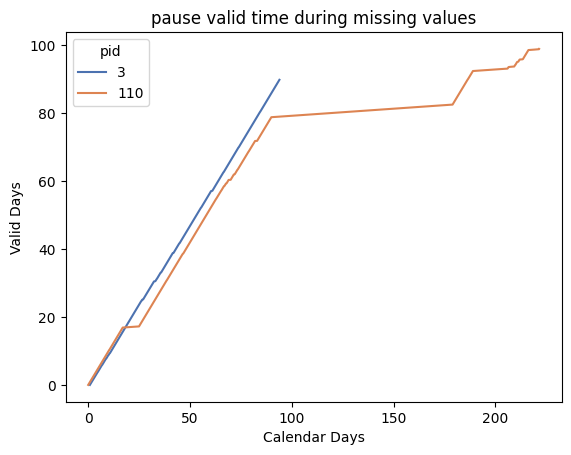

In [43]:
ax = sns.lineplot(res, x='time', y='valid_time', hue='pid', palette = sns.color_palette("deep")) # deep, muted, bright, pastel, dark, colorblind
ax.set_title('pause valid time during missing values')
ax.set_xlabel('Calendar Days')
ax.set_ylabel('Valid Days')

### Show predictions (still in rough shape)

In [217]:
res.loc[t0]['hour']

17.0

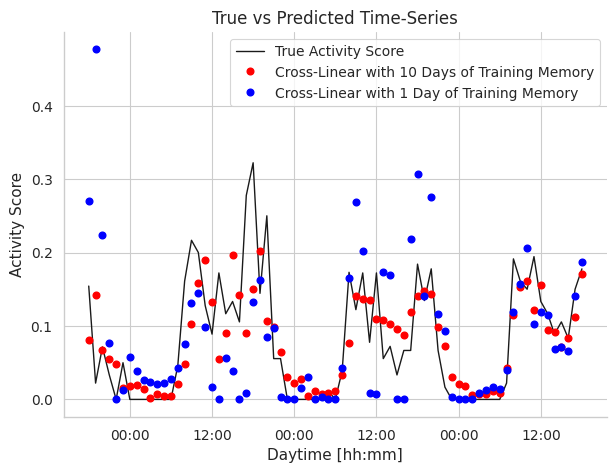

data points used 933
balance 0.7588424437299035


/tmp/ipykernel_1674297/356673181.py:71: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([0, ymax], [0, ymax], 'k--', color='gray')


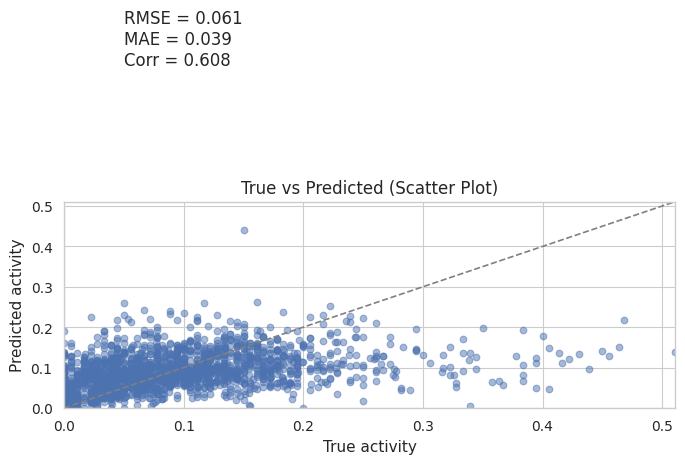

In [258]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error,roc_auc_score

# --- Original time-series plot ---

t_warm = 96 * 3 * 5 # ignore first 5 days for metrics
t0, t1 = 300 + t_warm, 372 + t_warm # visualize in plot
#shift = False # 1/3 error reduction by shifting

fig = plt.figure(figsize=(7, 5))
xtime = np.arange(len(res.loc[t0:t1]['y_true'])) + 18
plt.plot(xtime, res.loc[t0:t1]['y_true'],lw=1, label='Activited Score', c='k')
plt.plot(xtime, res.loc[t0:t1]['y_pred'],lw=0.,marker='o', label='Training Memory = 10 Days', c='red')
plt.plot(xtime, res2.loc[t0:t1]['y_pred'],lw=0.,marker='o', label='Training Memory = 1 Day', c='blue')
plt.xlabel('Daytime [hh:mm]')
plt.ylabel('Activity Score')
plt.legend(['True Activity Score', 'Cross-Linear with 10 Days of Training Memory', 'Cross-Linear with 1 Day of Training Memory']) 
plt.title('True vs Predicted Time-Series')
plt.grid(True)

# ticks
xticks = np.array([6,24-6,36-6,48-6,60-6, 72-6]) + 18
plt.gca().set_xticks(xticks)
xtick_labels = ['00:00', '12:00', '00:00', '12:00', '00:00','12:00']

#yticks = np.array([0,0.1,0.2,0.3])
yticks = np.array([0,0.1,0.2,0.3, 0.4])
plt.gca().set_yticks(yticks)
plt.gca().set_xticklabels(xtick_labels)

ax = plt.gca()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
fig.savefig("figures/time_series_prediction.jpg", dpi=300, bbox_inches='tight')
plt.show()

# Compute error metrics
non_sleep = False
if non_sleep:
    # Apply warm-up offset first
    df_eval = res.iloc[t_warm:].reset_index(drop=True)    
    print('Before time filter', len(df_eval))    
    # Filter for hours between 7:00 and 22:01
    df_eval = df_eval[(df_eval['hour'] >= 7.0) & (df_eval['hour'] <= 22.0)].reset_index(drop=True)
    
else:
    df_eval = res.iloc[t_warm:].reset_index(drop=True)
yt = df_eval['y_true']
yp = df_eval['y_pred']
print('data points used', len(yt))
target = df_eval['sb'] > 0    
print('balance',target.mean())
ymax = max(max(yt), max(yp))

rmse = np.sqrt(mean_squared_error(yt, yp))
mae = mean_absolute_error(yt, yp)
corr = np.corrcoef(yt, yp)[0, 1]
auc = roc_auc_score(target, yp)

# --- Scatter plot: True vs Predicted ---
plt.figure(figsize=(7, 7))
plt.scatter(res['y_true'], res['y_pred'], alpha=0.5)
plt.xlabel('True activity')
plt.ylabel('Predicted activity')
plt.title('True vs Predicted (Scatter Plot)')
plt.xlim([0, ymax])
plt.ylim([0, ymax])

# Add diagonal dashed line
plt.plot([0, ymax], [0, ymax], 'k--', color='gray')

# Annotate RMSE and MAE
metrics_text = f'RMSE = {rmse:.3f}\nMAE = {mae:.3f}\nCorr = {corr:.3f}'
if hr: metrics_text = metrics_text + f'\nAUC = {auc:.3f}'

plt.text(0.05, 0.85, metrics_text, fontsize=12, bbox=dict(facecolor='white', alpha=0.7))

#plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Sweeps: Run many settings

,pid,val_days
0,0,69.083333
1,1,11.291667
2,2,32.083333
3,3,89.750000
4,4,30.541667
...,...,...
145,145,10.666667
146,146,10.125000
147,147,96.458333
148,148,16.416667


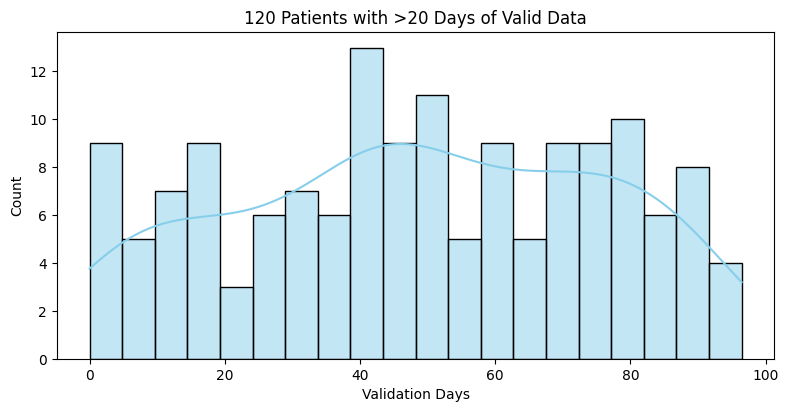

In [48]:
import seaborn as sns
min_vdays = 20
patient_quality = pd.read_csv('patient_quality.csv').iloc[:,1:]
plt.figure(figsize=(8, 4))
#_ = plt.hist(patient_quality.val_days, bins = 20)
sns.histplot(patient_quality.val_days, bins=20, kde=True, color="skyblue", edgecolor="black")
plt.xlabel("Validation Days"), plt.ylabel("Count"), plt.tight_layout()
plt.title(f'{np.sum(patient_quality.val_days > min_vdays)} Patients with >{min_vdays} Days of Valid Data')
#plt.title("Distribution of Validation Days per Patient"), 

patient_quality

In [15]:
from sklearn.utils import resample
from sklearn.metrics import mean_squared_error, mean_absolute_error,roc_auc_score

def balanced_auc(y_true, y_pred):
    y_true = pd.Series(y_true)
    y_pred = pd.Series(y_pred)
    min_class = y_true.value_counts().min()
    idx_bal = y_true.groupby(y_true).apply(lambda x: x.sample(min_class)).index.get_level_values(1)
    return roc_auc_score(y_true.loc[idx_bal], y_pred.loc[idx_bal])

In [22]:
# Most inclusive: 10 training, 10 evaluation <- include everyone
# Highest quality: 30 training, 60 evaluation <- reproduce results to find convergence cut-off with good patients

min_vday_tot = 20  # Preselect patients to have enough total data
min_vday_eval = 10  # Minimum days valid training days required for evaluation

qual_pid = patient_quality[patient_quality.val_days > min_vday_tot].pid.unique()
print(qual_pid)

results = []

for patient_id in tqdm.tqdm(qual_pid):
    for model_name in ['linear', 'poly2']:
        for train_days in [10]: # kernel        
            for inductive_bias in ['hour', 'day', 'cross','block']:
                for time_step in [5,15,60]:
                    for hr in [False]:
                        fac = int(60 / time_step)
                        train_hours = train_days * 24 if train_days else None
                        model = f'{inductive_bias}-{model_name}'
    
                        res = run(
                            patient_id=patient_id,
                            kernel_day=3,
                            kernel_hour=5 * fac,
                            model=model,
                            time_step=time_step,
                            nan_thres=1.01,
                            alpha_reg=0.001,
                            hr=hr,
                            train_hours=train_hours,
                            prints=False,
                            min_days=min_vday_tot
                        )
    
                        if isinstance(res, int):
                            continue  # Skip if result is -1 or not a DataFrame
    
                        for no_sleep in [True, False]:
                            df_eval = res.copy()
    
                            if no_sleep:
                                df_eval = df_eval[
                                    (df_eval['hour'] >= 7.0) &
                                    (df_eval['hour'] <= 22.0) &
                                    (df_eval.valid_time > min_vday_eval)
                                ].reset_index(drop=True)
                            else:
                                df_eval = df_eval[df_eval.valid_time > min_vday_eval].reset_index(drop=True)
    
                            if len(df_eval) == 0:
                                continue
    
                            yt = df_eval['y_true']
                            yp = df_eval['y_pred']
                            target = df_eval['sb'] > 0
    
                            rmse = np.sqrt(mean_squared_error(yt, yp))
                            mae = mean_absolute_error(yt, yp)
                            corr = np.corrcoef(yt, yp)[0, 1]
                            auc = roc_auc_score(target, yp)
                            auc_bal = balanced_auc(target, yp)
                            bal = target.mean()
    
                            metrics = {
                                'rmse': rmse,
                                'mae': mae,
                                'corr': corr,
                                'auc': auc,
                                'auc_bal': auc_bal,
                                'bal': bal,
                                'min_vday_eval': min_vday_eval,
                                'train_days': train_days,
                                'no_sleep': no_sleep,
                                'hr': hr,
                                'time_step': time_step,
                                'model': model,
                                'patient_id': patient_id,
                            }
    
                            metrics.update(res.iloc[0][['valid_days', 'nan_days', 'total_days']].to_dict())
                            results.append(metrics)

results = pd.DataFrame(results)
results.to_csv('./results_08_05_2025.csv')

[  0   2   3   4   5   6   7   8  10  12  13  14  15  16  17  20  21  22
  24  25  26  27  28  29  30  31  32  33  34  36  37  39  40  41  42  43
  44  46  47  48  50  51  52  53  54  55  56  57  58  59  60  61  62  63
  64  65  66  67  68  69  70  71  73  74  77  78  79  80  81  82  83  84
  85  86  87  91  92  94  95  96  97  98 100 101 102 103 104 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 128 129 130 131
 132 134 135 137 138 140 141 142 143 144 147 149]


100%|██████████| 120/120 [05:44<00:00,  2.87s/it]


AttributeError: module 'pandas' has no attribute 'to_csv'

# 6. Load results, plot and save figures.

In [129]:
RESULTS_PATH = "/sc/arion/work/jegmij01/patchtst/datasets/private/cpp/"
window = 60
#df = pd.read_csv(f"{RESULTS_PATH}/final_img_activity_{window}.csv")
df = pd.read_csv(f"{RESULTS_PATH}/final_nan_img_activity_{window}.csv")

/tmp/ipykernel_1674297/2258325391.py:12: RuntimeWarning: invalid value encountered in scalar divide
  stats.append({'Total Data [days]':total_days, 'Valid Data [days]':val_days, 'Missing Data [days]': total_days - val_days, 'Valid Ratio': val_days/total_days})


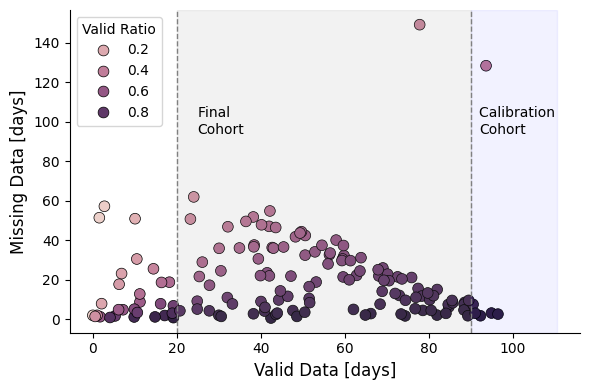

In [140]:
import seaborn as sns
import matplotlib.pyplot as plt

stats = []
for pid in df['patient_count'].unique():
    val = df[df['patient_count'] == pid].iloc[:,2:].values
    val = trim_nan_rows(val.copy())
    val_days = np.sum(np.sum(~np.isnan(val))) / 24  # Assuming 24 time points per day        
    total_days = val.size / 24  # Assuming 24 time points per day    
    #assert total_days > 0, f'{pid}, not even a single day??'
    assert round(np.isnan(val).sum().sum() / 24,2)== round(total_days - val_days,2)
    stats.append({'Total Data [days]':total_days, 'Valid Data [days]':val_days, 'Missing Data [days]': total_days - val_days, 'Valid Ratio': val_days/total_days})
stats = pd.DataFrame(stats)
stats = stats.dropna()

# Plot
plt.figure(figsize=(6, 4))
scatter = sns.scatterplot(
    data=stats,
    x='Valid Data [days]',
    y='Missing Data [days]',
    hue='Valid Ratio',
    #palette='tab20',  # or any other suitable palette
    edgecolor='black',
    linewidth=0.5,
    s=60
)

# Axis labels and title
plt.xlabel('Valid Data [days]', fontsize=12)
plt.ylabel('Missing Data [days]', fontsize=12)

plt.axvline(20, color='gray', linestyle='--', linewidth=1)
plt.axvline(90, color='gray', linestyle='--', linewidth=1)

plt.axvspan(20, 90, color='gray', alpha=0.1)
plt.axvspan(90, stats['Valid Data [days]'].max()+14, color='blue', alpha=0.05)

# Add text labels
plt.text(25, plt.ylim()[1]*0.6, 'Final \nCohort', fontsize=10, color='black')
plt.text(92, plt.ylim()[1]*0.6, 'Calibration \nCohort', fontsize=10, color='black')

# Layout and style
sns.despine()
plt.tight_layout()
plt.savefig("figures/scatter_valid_vs_missing.jpg", dpi=300, bbox_inches='tight')

### Result plots

In [53]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

results_hq = pd.read_csv('./results_05_05_2025.csv')
results_all = pd.read_csv('./results_all_pids_05_05_2025.csv') # min_vday_tot = 20, min_vday_eval = 11, train_days=10
results_models = pd.read_csv('./results_08_05_2025.csv')
#results_poly = pd.read_csv('./results_08_05_2025.csv')


/tmp/ipykernel_2253528/351592353.py:46: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_plot = results.set_index([names['hr'], names['no_sleep'], names['time_step']]).loc[(hr, no_sleep, time_step)].reset_index()


Saved figure: figures/convergence_group_rmse_hr0_t60.jpg


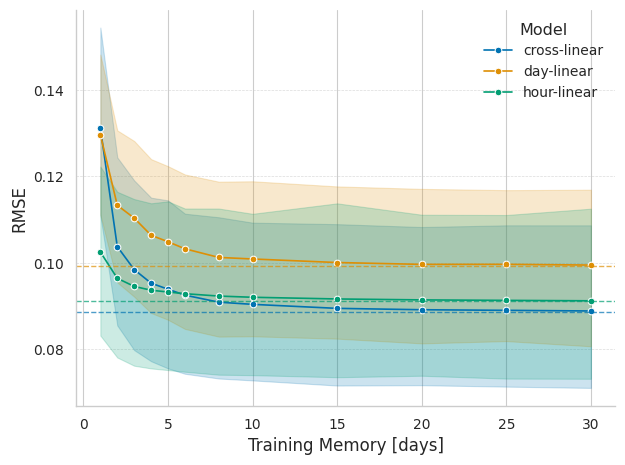

/tmp/ipykernel_2253528/351592353.py:46: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_plot = results.set_index([names['hr'], names['no_sleep'], names['time_step']]).loc[(hr, no_sleep, time_step)].reset_index()


Saved figure: figures/convergence_group_auc_hr0_t60.jpg


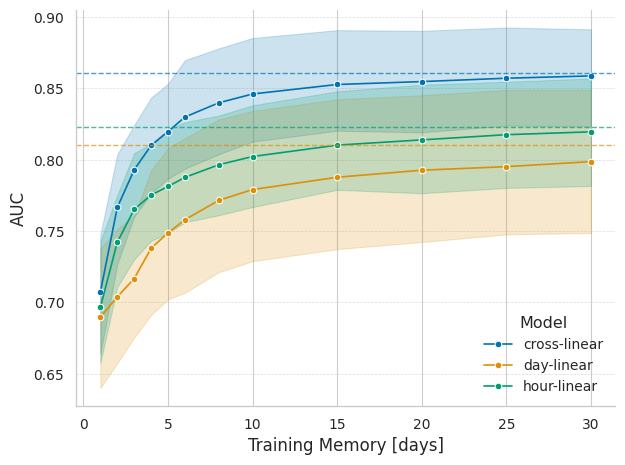

/tmp/ipykernel_2253528/351592353.py:46: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_plot = results.set_index([names['hr'], names['no_sleep'], names['time_step']]).loc[(hr, no_sleep, time_step)].reset_index()


Saved figure: figures/convergence_group_auc_bal_hr0_t60.jpg


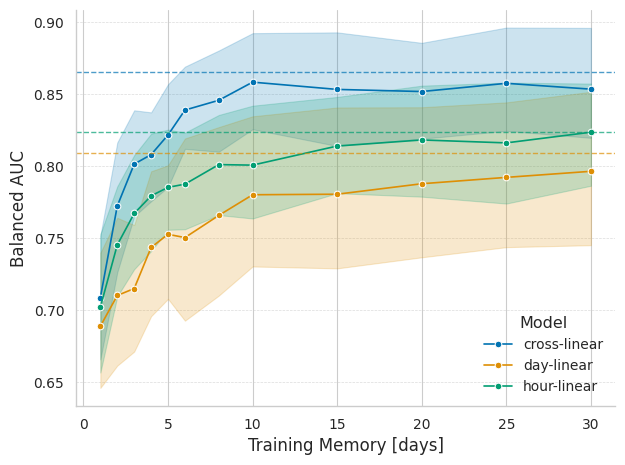

In [80]:
import seaborn as sns
import os
from sklearn.metrics import mean_absolute_error, mean_squared_error
from scipy.stats import pearsonr

sns.set_context("paper", font_scale=1.2)  # better for publication
sns.set_style("whitegrid")  # clean and light grid background
plt.rcParams.update({
    #"font.family": "sans-serif",
    #"font.sans-serif": ["Arial"],
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

results = results_hq.copy()

fig_dir = 'figures' # dir to save
# variable names in plot
names = { 
    'rmse': 'RMSE',
    'mae': 'MAE',
    'corr': 'Correlation',
    'auc': 'AUC',
    'auc_bal': 'Balanced AUC',
    'min_vday_eval': 'Eval. Days (Floor)',
    'train_days': r'Training Memory [day]',
    'bal': 'Label Balance',
    'no_sleep': 'Evaluation Interval',
    'hr': 'Modality',
    'time_step': 'Time Step (min)',
    'model': 'Model',    
    'patient_id': 'Patient ID',
    'valid_days' : 'Valid Data [day]',
    'nan_days' : 'Missing Data [day]',
    'total_days' : 'Total Data [day]'
}


def convergence_plot(results, metric='rmse', hr=False, time_step=60, no_sleep=False, patient_id=None):
    if patient_id:
        df_plot = results.set_index([names['patient_id'], names['hr'], names['no_sleep'], names['time_step']]).loc[(patient_id, hr, no_sleep, time_step)].reset_index()
    else:
        df_plot = results.set_index([names['hr'], names['no_sleep'], names['time_step']]).loc[(hr, no_sleep, time_step)].reset_index()

    df_plot = df_plot.sort_values(names['model'])
    model_names = df_plot[names['model']].unique()
    colors = sns.color_palette("colorblind", len(model_names))
    palette = dict(zip(model_names, colors))

    ax = sns.lineplot(
        data=df_plot,
        x=names['train_days'],
        y=names[metric],
        hue=names['model'],
        marker='o',
        palette=palette
    )

    # Convergence horizontal lines
    df_converge = df_plot[df_plot[names['train_days']].isna()].groupby(names['model']).mean(numeric_only=True)[names[metric]].sort_index()
    for (model_name, metric_value), color in zip(df_converge.items(), colors):
        ax.axhline(y=metric_value, linestyle='--', color=color, alpha=0.7, linewidth=1)

        if False:
            ax.text(
                x=max(df_plot.index)+0.5,
                y=metric_value,
                s=f"{metric_value:.2f}",
                va='center',
                ha='left',
                fontsize=9,
                color=color
            )
    
    # Axes and style
    ax.set_xlabel('Training Memory [days]', fontsize=12)
    ax.set_ylabel(names[metric], fontsize=12)
    ax.legend(title='Model', loc='best', frameon=False)
    ax.grid(True, which='major', axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

    sns.despine()
    plt.tight_layout()

    return ax, f"{names[metric]} Performance vs Training Days"


def plot_hr_vs_act(results_hq, model, no_sleep, time_step):
    for metric in ['auc', 'corr']:        
        results = results_hq.copy().rename(columns=names)        
        results[names['hr']] = results[names['hr']].apply(lambda x: "Heart Rate" if x else "Activity Score")
        df_plot = results.set_index([names['model'], names['no_sleep'], names['time_step']])\
                         .loc[(model, no_sleep, time_step)].reset_index()
        ax = sns.lineplot(df_plot, x=names['train_days'], y=names[metric], hue=names['hr'], marker='o')

        # Plot asymptotic values as horizontal dashed lines
        df_asympt = df_plot[df_plot[names['train_days']].isna()]\
                          .groupby(names['hr']).mean(numeric_only=True)[names[metric]].sort_index()
        colors = sns.color_palette()
        for (modality_name, metric_value), color in zip(df_asympt.items(), colors):
            plt.axhline(y=metric_value, linestyle='--', color=color, label=modality_name)
        # Title and save        
        title = f"{names[metric]} Performance vs Training Days"
        return ax, title

os.makedirs(fig_dir, exist_ok=True)

def save_and_show(ax, title, filename):
    plt.sca(ax)
    plt.title(title)
    full_path = os.path.join(fig_dir, filename)
    plt.savefig(full_path, bbox_inches='tight', dpi=300)
    print(f"Saved figure: {full_path}")
    plt.show()
    plt.close()

plot_flags = {
    'pid_7': False,
    'pid_110': False,
    'group_hr': True,
    'hr_vs_act': False,
    'bar_time_step_vs_sleep':False,
    'bar_models_vs_sleep':False,
    'scatter_auc_vs_auc_bal':False,
}

hr = False
time_step = 60
results = results_hq.copy()
results = results.rename(columns=names)

#[  7  22  51  86 110 147]

if plot_flags['pid_7']:
    pid = 7
    for metric in ['rmse', 'auc']:
        ax,tit = convergence_plot(results, metric=metric, hr=hr, time_step=60, no_sleep=False, patient_id=pid)        
        fname = f"convergence_pid{pid}_{metric}_hr{int(hr)}.png"
        save_and_show(ax, tit, fname)

if plot_flags['pid_110']:
    pid = 110
    for metric in ['rmse', 'auc']:
        ax,tit = convergence_plot(results, metric=metric, hr=hr, time_step=60, no_sleep=False, patient_id=pid)                
        fname = f"convergence_pid{pid}_{metric}_hr{int(hr)}.png"
        save_and_show(ax, tit, fname)

if plot_flags['group_hr']:
    for metric in ['rmse', 'auc', 'auc_bal']:
        ax,tit = convergence_plot(results, metric=metric, hr=hr, time_step=60, no_sleep=False, patient_id=None)                        
        fname = f"convergence_group_{metric}_hr{int(hr)}_t{time_step}.jpg"
        tit = ''
        save_and_show(ax, tit, fname)

    # print results
    idx = (results[names['hr']] == False) & (results[names['no_sleep']]==False) & (results[names['train_days']].isna())
    print_res = results[idx].groupby('Model').mean()[['RMSE','AUC','Balanced AUC']].round(3)
    idx = (results[names['hr']] == False) & (results[names['no_sleep']]==False)
    print_res2 = results[idx].groupby(['Model',names['train_days']]).mean()[['RMSE','AUC','Balanced AUC']].round(3)
        

if plot_flags['hr_vs_act']:
    model = 'cross-linear'
    time_step = 60 # AUC seems to have only one guy.
    for metric in ['auc', 'corr']:                
        results = results_hq.copy().rename(columns=names)    
        results[names['hr']] = results[names['hr']].apply(lambda x : {True: "Heart Rate",False: "Activity Score"}[x])        
        df_plot = results.set_index([names['model'],names['no_sleep'],names['time_step']]).loc[(model, no_sleep, time_step)].reset_index()#.sort_values()        
        ax = sns.lineplot(df_plot, x=names['train_days'],y=names[metric],hue=names['hr'],marker='o')
        # asymtotic values:
        df_plot = df_plot[df_plot[names['train_days']].isna()].groupby(names['hr']).mean(numeric_only=True)[names[metric]].sort_index()
        colors = sns.color_palette()
        for (modality_name, metric_value), color in zip(df_plot.items(), colors): 
            plt.axhline(y=metric_value, linestyle='--', color=color, label=modality_name)
        tit = f"{names[metric]} Performance vs Training Memory"
        fname = f"hr_vs_act_{metric}.jpg"
        save_and_show(ax, tit, fname)

if plot_flags['bar_time_step_vs_sleep']:
    for metric in ['rmse', 'auc']:        
        results = results_all.copy().rename(columns=names)
        idx = (results[names['hr']] == hr) & (results[names['model']] == 'cross-linear') & (results[names['train_days']].isna())
        ax = sns.barplot(results[idx], x=names['time_step'], hue=names['no_sleep'], y=names[metric])        
        ax.grid()
        filename = f"bar_time_step_vs_sleep_{metric}_hr{int(hr)}.jpg"
        tit = f"{names[metric]} vs Time Step and {names['no_sleep']}"
        save_and_show(ax, tit, filename)

if plot_flags['bar_models_vs_sleep']:
    hr = False
    results = results_models.copy().rename(columns=names)
    for metric in ['rmse', 'auc']:                
        results[names['no_sleep']] = results[names['no_sleep']].map({True: "7am - 10pm", False: "24 hours"})
        #idx = (results[names['hr']] == hr) & (results[names['model']] == 'cross-linear') & (results[names['train_days']]==10)
        ax = sns.barplot(results, x=names['model'], hue=names['no_sleep'], y=names[metric])
        sns.despine()
        plt.xticks(rotation=45)
        ax.grid(True, linestyle='--', color='gray', alpha=0.5)
        
        filename = f"bar_model_vs_sleep_{metric}_hr{int(hr)}.jpg"
        tit = f"{names[metric]} vs Models and {names['no_sleep']}"
        save_and_show(ax, tit, filename)

    # print results
    idx = (results[names['hr']] == False) & (results[names['train_days']]==10)
    results[idx].groupby(['Model','Evaluation Interval']).mean()[['RMSE','AUC']].round(3)


if plot_flags['scatter_auc_vs_auc_bal']:

    hr = False
    no_sleep = False
    
    results = results_models.copy().rename(columns=names)
    results['Valid Data Ratio'] = results[names['valid_days']]/results[names['total_days']]
    results[names['bal']] = 1 - results[names['bal']] # from non-SB to SB balance
    idx = (results[names['no_sleep']]==no_sleep) & (results[names['model']] == 'cross-linear')    

    fig, ax = plt.subplots(figsize=(5, 5))  # square plot
    #sns.despine()
    sns.scatterplot(results[idx], x=names['auc'], y=names['auc_bal'],hue=names['bal'], ax=ax, edgecolor='black',linewidth=0.5,s=60)

    x = results.loc[idx, names['auc']]
    y = results.loc[idx, names['auc_bal']]
    lims = [min(x.min(), y.min()), max(x.max(), y.max())]
    ax.plot(lims, lims, 'k--', alpha=0.5)

    ax.grid(True, linestyle='--', color='gray', alpha=0.5)
    ax.set_aspect('equal', adjustable='box')

    # Add metrics as text
    corr, _ = pearsonr(x, y)
    ax.text(0.05, 0.95, f"Correlation: {corr:.3f}",
            transform=ax.transAxes, verticalalignment='top', fontsize=13, bbox=dict(facecolor='white', alpha=0.6))

    #ax.legend(loc='lower right')
    ax.legend(title='SB-Ratio', loc='lower right')
    
    filename = f"scatter_auc_balance_hr{int(hr)}_no_sleep{int(no_sleep)}.jpg"
    tit = f"AUC vs Balanced AUC for Cross-Linear Model"
    save_and_show(ax, tit, filename)


In [61]:
idx = (results[names['hr']] == False) & (results[names['train_days']]==10)
results[idx].groupby(['Model','Evaluation Interval']).mean()[['RMSE','AUC']].round(3)

RMSE    AUC
Model        Evaluation Interval              
block-linear 24 hours             0.099  0.790
             7am - 10pm           0.115  0.734
block-poly2  24 hours             0.201  0.682
             7am - 10pm           0.217  0.618
cross-linear 24 hours             0.095  0.826
             7am - 10pm           0.112  0.766
cross-poly2  24 hours             0.109  0.805
             7am - 10pm           0.126  0.732
day-linear   24 hours             0.105  0.766
             7am - 10pm           0.123  0.653
day-poly2    24 hours             0.106  0.778
             7am - 10pm           0.124  0.650
hour-linear  24 hours             0.097  0.787
             7am - 10pm           0.112  0.772
hour-poly2   24 hours             0.100  0.788
             7am - 10pm           0.116  0.766

In [82]:
print_res2

RMSE    AUC  Balanced AUC
Model        Training Memory [day]                            
cross-linear 1.0                    0.122  0.738         0.739
             2.0                    0.106  0.783         0.784
             3.0                    0.102  0.802         0.805
             4.0                    0.100  0.813         0.813
             5.0                    0.099  0.820         0.820
             6.0                    0.098  0.826         0.830
             8.0                    0.097  0.833         0.834
             10.0                   0.096  0.837         0.841
             15.0                   0.096  0.843         0.844
             20.0                   0.096  0.846         0.845
             25.0                   0.095  0.849         0.849
             30.0                   0.095  0.850         0.849
day-linear   1.0                    0.144  0.642         0.642
             2.0                    0.134  0.653         0.655
             3.0                    0.131  0.663         0.663
             4.0                    0.129  0.677         0.679
             5.0                    0.128  0.685         0.686
             6.0                    0.127  0.693         0.690
             8.0                    0.126  0.704         0.702
             10.0                   0.125  0.709         0.709
             15.0                   0.125  0.717         0.715
             20.0                   0.125  0.723         0.721
             25.0                   0.125  0.725         0.725
             30.0                   0.124  0.728         0.727
hour-linear  1.0                    0.109  0.739         0.741
             2.0                    0.102  0.773         0.774
             3.0                    0.100  0.789         0.790
             4.0                    0.099  0.797         0.799
             5.0                    0.099  0.802         0.804
             6.0                    0.098  0.807         0.807
             8.0                    0.098  0.813         0.815
             10.0                   0.097  0.817         0.817
             15.0                   0.097  0.824         0.825
             20.0                   0.097  0.827         0.829
             25.0                   0.096  0.830         0.830
             30.0                   0.096  0.832         0.834

### Performance vs valid ratio

/tmp/ipykernel_1674297/53120260.py:36: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_plot = df_plot.loc[(hr, no_sleep, time_step, train_days, 'cross-linear')].reset_index()


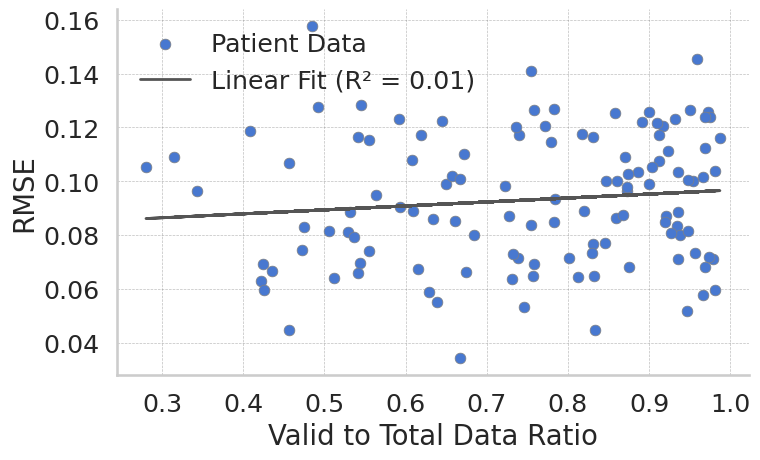

/tmp/ipykernel_1674297/53120260.py:36: PerformanceWarning: indexing past lexsort depth may impact performance.
  df_plot = df_plot.loc[(hr, no_sleep, time_step, train_days, 'cross-linear')].reset_index()


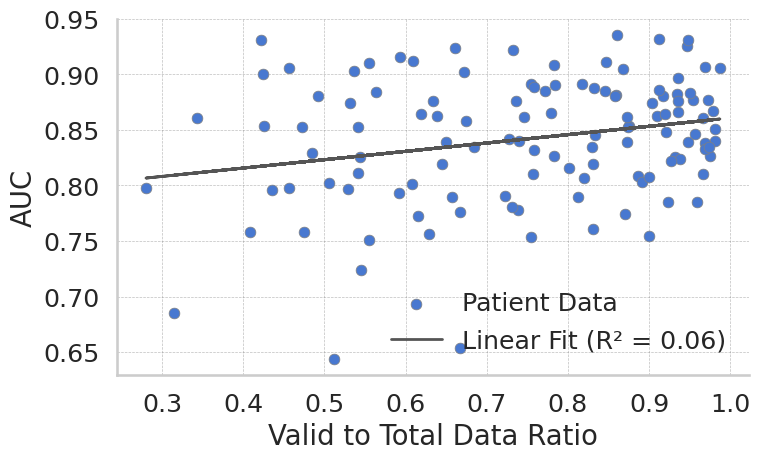

In [171]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("paper", font_scale=1.2)  # better for publication
sns.set_style("whitegrid")  # clean and light grid background
plt.rcParams.update({
    #"font.family": "sans-serif",
    #"font.sans-serif": ["Arial"],
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10
})

# Set seaborn style with lighter grid
sns.set(style="whitegrid", context="talk", font_scale=1.1)

# Parameters
hr, no_sleep, time_step = False, False, 60
train_days = np.nan
x = 'Valid Ratio'

for metric in ['rmse','auc']:
    
    # Create figure
    fig, ax = plt.subplots(figsize=(8, 5))
    

    
    # Prepare data
    df_plot = results_all.copy().rename(columns=names).set_index([
        names['hr'], names['no_sleep'], names['time_step'], names['train_days'], names['model']])
    df_plot = df_plot.loc[(hr, no_sleep, time_step, train_days, 'cross-linear')].reset_index()
    df_plot[x] = df_plot[names['valid_days']] / df_plot[names['total_days']]
    
    # Linear regression
    x_vals = df_plot[x].values.reshape(-1, 1)
    y_vals = df_plot[names[metric]].values
    reg = LinearRegression().fit(x_vals, y_vals)
    y_pred = reg.predict(x_vals)
    r2 = r2_score(y_vals, y_pred)
    
    # Scatter plot with muted color
    sns.scatterplot(
        data=df_plot, x=x, y=names[metric], 
        s=60, color=sns.color_palette("muted")[0], 
        edgecolor='gray', linewidth=0.5, ax=ax, label='Patient Data' # hue=names['bal'] #
    )
    
    # Regression line in dark gray
    ax.plot(df_plot[x], y_pred, color='#555555', linewidth=2, label=f'Linear Fit (R² = {r2:.2f})')
    
    # Axis labels
    ax.set_xlabel("Valid to Total Data Ratio")#, fontsize=15)
    ax.set_ylabel(names[metric]) #, fontsize=15)
    
    ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.5, color='gray')
    
    # Legend & formatting
    ax.legend(frameon=False)
    sns.despine()
    plt.tight_layout()
    
    # Save
    plt.savefig(f"figures/scatter_{names[metric]}_vs_valid_ratio.jpg", dpi=300, bbox_inches='tight')
    plt.show()